Funding Rate Direction Prediction using Machine Learning
This script predicts whether the next funding rate will be positive or negative
Using Support Vector Machine (SVM) classifier

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    roc_auc_score, roc_curve, precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from pathlib import Path
BASE_PATH = Path.cwd()
FEATURE_COLS = [
    # Basis features (most important for funding rate prediction)
    'basis', 'basis_30m_avg', 'basis_1h_avg', 'basis_4h_avg',
    'basis_change_30m', 'basis_change_1h',
    'basis_min_30m', 'basis_min_1h',
    'basis_std_30m', 'basis_std_1h', 'basis_std_24h',
    'basis_zscore_30m', 'basis_zscore_1h', 'basis_zscore_24h',

    # Taker imbalance (futures)
    'taker_buy_ratio', 'futures_taker_buy_30m_avg', 'futures_taker_buy_1h_avg',
    'futures_taker_zscore',

    # Taker imbalance (spot)
    'spot_taker_buy_ratio',

    # Futures vs Spot taker difference
    'taker_futures_spot_diff',

    # Price momentum
    'ret_30m', 'ret_1h', 'ret_4h', 'ret_24h',
    'volatility_30m', 'volatility_1h', 'volatility_4h',

    # Volume
    'volume_zscore_30m', 'volume_zscore_1h', 'volume_zscore_4h', 'volume_zscore_24h',
    'trade_count_zscore_30m', 'trade_count_zscore_1h', 'trade_count_zscore_4h', 'trade_count_zscore_24h',

    # Funding rate history (CRITICAL - but only past values!)
    'prev_fr', 'prev_fr_avg_3', 'consecutive_neg',

    # Time features
    'hour_of_day', 'day_of_week'
]

In [3]:
# DATA LOADING FUNCTIONS
# ============================================================

def load_futures_data(symbol, timeframe, base_path=BASE_PATH):
    """Load futures (perpetual) price data."""
    print("="*60)
    print("LOADING FUTURES (PERPS) DATA")
    print("="*60)

    futures_path = base_path / 'raw_historical_price' / f'{symbol}_{timeframe}_binance_futures_historical_data.json'
    df_futures = pd.read_json(futures_path, orient='records', lines=True)

    # Convert timestamp and set as index
    df_futures['datetime'] = pd.to_datetime(df_futures['datetime'])
    df_futures = df_futures.sort_values('datetime').drop_duplicates(subset=['datetime'])
    df_futures.set_index('datetime', inplace=True)

    # Convert all numeric columns to float
    futures_numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
                            'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
    for col in futures_numeric_cols:
        df_futures[col] = df_futures[col].astype(float)

    # Keep only relevant columns
    df_futures = df_futures[futures_numeric_cols]

    print(f"Loaded {len(df_futures)} rows of {symbol} FUTURES data")
    print(f"Date range: {df_futures.index.min()} to {df_futures.index.max()}")

    return df_futures


def load_spot_data(symbol, timeframe, base_path=BASE_PATH):
    """Load spot price data."""
    print("\n" + "="*60)
    print("LOADING SPOT DATA")
    print("="*60)

    spot_path = base_path / 'raw_historical_price' / f'{symbol}_{timeframe}_binance_spot_historical_data.json'
    df_spot = pd.read_json(spot_path, orient='records', lines=True)

    # Convert timestamp and set as index
    df_spot['datetime'] = pd.to_datetime(df_spot['datetime'])
    df_spot = df_spot.sort_values('datetime').drop_duplicates(subset=['datetime'])
    df_spot.set_index('datetime', inplace=True)

    # Convert all numeric columns to float
    spot_numeric_cols = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
                         'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
    for col in spot_numeric_cols:
        df_spot[col] = df_spot[col].astype(float)

    # Keep only relevant columns and rename with spot_ prefix
    df_spot = df_spot[spot_numeric_cols]
    df_spot = df_spot.rename(columns={col: f'spot_{col}' for col in spot_numeric_cols})

    print(f"Loaded {len(df_spot)} rows of {symbol} SPOT data")
    print(f"Date range: {df_spot.index.min()} to {df_spot.index.max()}")

    return df_spot


def load_funding_rate(symbol, base_path=BASE_PATH):
    """Load funding rate data."""
    print("\n" + "="*60)
    print("LOADING FUNDING RATE DATA")
    print("="*60)

    funding_rate_path = base_path / 'raw_funding_rate' / f'{symbol}_funding_rate_20200101_20251130.csv'
    df_funding = pd.read_csv(funding_rate_path)

    # Convert datetime and set as index
    df_funding['datetime'] = pd.to_datetime(df_funding['fundingDateTime'])
    df_funding = df_funding.sort_values('datetime').drop_duplicates(subset=['datetime'])
    df_funding.set_index('datetime', inplace=True)

    # Keep relevant columns
    df_funding = df_funding[['fundingRate', 'markPrice']]
    df_funding['fundingRate'] = df_funding['fundingRate'].astype(float)
    df_funding['markPrice'] = df_funding['markPrice'].astype(float)

    print(f"Loaded {len(df_funding)} rows of {symbol} FUNDING RATE data")
    print(f"Date range: {df_funding.index.min()} to {df_funding.index.max()}")

    return df_funding


def merge_all_data(df_futures, df_spot, df_funding):
    """Merge futures, spot, and funding rate data."""
    print("\n" + "="*60)
    print("MERGING ALL DATA")
    print("="*60)

    # Step 1: Merge Futures + Spot (inner join to keep only overlapping timestamps)
    df_merged = df_futures.merge(
        df_spot,
        how='inner',
        left_index=True,
        right_index=True
    )
    print(f"After Futures + Spot merge: {len(df_merged)} rows")

    # Step 2: Merge with Funding Rate (left join)
    df_merged = df_merged.merge(
        df_funding,
        how='left',
        left_index=True,
        right_index=True
    )
    print(f"After adding Funding Rate: {len(df_merged)} rows")
    print(f"Rows with funding rate: {df_merged['fundingRate'].notna().sum()}")

    return df_merged

In [4]:
# FEATURE ENGINEERING FUNCTIONS
# ============================================================

def calculate_features(df_merged):
    """Calculate all derived features for ML."""
    print("\n" + "="*60)
    print("CALCULATING DERIVED FEATURES")
    print("="*60)

    df = df_merged.copy()

    # Basis = (Futures - Spot) / Spot * 100 (in percentage)
    df['basis'] = (df['close'] - df['spot_close']) / df['spot_close'] * 100

    # Taker buy ratios
    df['taker_buy_ratio'] = df['taker_buy_base_asset_volume'] / df['volume']
    df['spot_taker_buy_ratio'] = df['spot_taker_buy_base_asset_volume'] / df['spot_volume']

    # Returns
    df['returns'] = df['close'].pct_change()
    df['spot_returns'] = df['spot_close'].pct_change()

    # --- 1. BASIS FEATURES ---
    df['basis_30m_avg'] = df['basis'].rolling(6).mean()
    df['basis_1h_avg'] = df['basis'].rolling(12).mean()
    df['basis_4h_avg'] = df['basis'].rolling(48).mean()
    df['basis_change_30m'] = df['basis'] - df['basis'].shift(6)
    df['basis_change_1h'] = df['basis'] - df['basis'].shift(12)
    df['basis_min_30m'] = df['basis'].rolling(6).min()
    df['basis_min_1h'] = df['basis'].rolling(12).min()
    df['basis_std_30m'] = df['basis'].rolling(6).std()
    df['basis_std_1h'] = df['basis'].rolling(12).std()
    df['basis_std_24h'] = df['basis'].rolling(288).std()

    # Z-scores for different timeframes
    basis_30m_mean = df['basis'].rolling(6).mean()
    basis_30m_std = df['basis'].rolling(6).std()
    df['basis_zscore_30m'] = (df['basis'] - basis_30m_mean) / basis_30m_std

    basis_1h_mean = df['basis'].rolling(12).mean()
    basis_1h_std = df['basis'].rolling(12).std()
    df['basis_zscore_1h'] = (df['basis'] - basis_1h_mean) / basis_1h_std

    basis_24h_mean = df['basis'].rolling(288).mean()
    basis_24h_std = df['basis'].rolling(288).std()
    df['basis_zscore_24h'] = (df['basis'] - basis_24h_mean) / basis_24h_std

    # --- 2. TAKER IMBALANCE FEATURES ---
    df['futures_taker_buy_30m_avg'] = df['taker_buy_ratio'].rolling(6).mean()
    df['futures_taker_buy_1h_avg'] = df['taker_buy_ratio'].rolling(12).mean()

    taker_rolling_mean = df['taker_buy_ratio'].rolling(288).mean()
    taker_rolling_std = df['taker_buy_ratio'].rolling(288).std()
    df['futures_taker_zscore'] = (df['taker_buy_ratio'] - taker_rolling_mean) / taker_rolling_std

    df['spot_taker_buy_30m_avg'] = df['spot_taker_buy_ratio'].rolling(6).mean()
    df['spot_taker_buy_1h_avg'] = df['spot_taker_buy_ratio'].rolling(12).mean()

    spot_taker_mean = df['spot_taker_buy_ratio'].rolling(288).mean()
    spot_taker_std = df['spot_taker_buy_ratio'].rolling(288).std()
    df['spot_taker_zscore'] = (df['spot_taker_buy_ratio'] - spot_taker_mean) / spot_taker_std

    df['taker_futures_spot_diff'] = df['taker_buy_ratio'] - df['spot_taker_buy_ratio']

    # --- 3. PRICE MOMENTUM FEATURES ---
    df['ret_30m'] = df['close'].pct_change(6)
    df['ret_1h'] = df['close'].pct_change(12)
    df['ret_4h'] = df['close'].pct_change(48)
    df['ret_24h'] = df['close'].pct_change(288)
    df['volatility_30m'] = df['returns'].rolling(6).std()
    df['volatility_1h'] = df['returns'].rolling(12).std()
    df['volatility_4h'] = df['returns'].rolling(48).std()

    # --- 4. VOLUME FEATURES ---
    df['volume_zscore_30m'] = (df['volume'] - df['volume'].rolling(6).mean()) / df['volume'].rolling(6).std()
    df['volume_zscore_1h'] = (df['volume'] - df['volume'].rolling(12).mean()) / df['volume'].rolling(12).std()
    df['volume_zscore_4h'] = (df['volume'] - df['volume'].rolling(48).mean()) / df['volume'].rolling(48).std()
    df['volume_zscore_24h'] = (df['volume'] - df['volume'].rolling(288).mean()) / df['volume'].rolling(288).std()

    df['trade_count_zscore_30m'] = (df['number_of_trades'] - df['number_of_trades'].rolling(6).mean()) / df['number_of_trades'].rolling(6).std()
    df['trade_count_zscore_1h'] = (df['number_of_trades'] - df['number_of_trades'].rolling(12).mean()) / df['number_of_trades'].rolling(12).std()
    df['trade_count_zscore_4h'] = (df['number_of_trades'] - df['number_of_trades'].rolling(48).mean()) / df['number_of_trades'].rolling(48).std()
    df['trade_count_zscore_24h'] = (df['number_of_trades'] - df['number_of_trades'].rolling(288).mean()) / df['number_of_trades'].rolling(288).std()

    # --- 5. FUNDING RATE HISTORY FEATURES ---
    df['prev_fr'] = df['fundingRate'].ffill()
    df['next_fr'] = df['fundingRate'].bfill()

    funding_only = df[df['fundingRate'].notna()]['fundingRate']
    fr_rolling_avg = funding_only.rolling(3).mean()
    df['prev_fr_avg_3'] = fr_rolling_avg.reindex(df.index).ffill()

    df['is_funding_event'] = df['fundingRate'].notna()

    # Consecutive negative funding count
    def calc_consecutive_neg(series):
        funding_vals = series[series.notna()]
        streaks = []
        current_streak = 0
        for val in funding_vals:
            if val < 0:
                current_streak += 1
            else:
                current_streak = 0
            streaks.append(current_streak)
        return pd.Series(streaks, index=funding_vals.index)

    consec_neg = calc_consecutive_neg(df['fundingRate'])
    df['consecutive_neg'] = consec_neg.reindex(df.index).ffill().fillna(0)

    # --- 6. TIME FEATURES ---
    df['hour_of_day'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek

    print("ML Features calculated successfully!")
    print(f"Total columns: {len(df.columns)}")

    return df

In [5]:
# ANALYSIS FUNCTIONS (OPTIONAL)
# ============================================================

def analyze_funding_intervals(df_merged, symbol, show_plots=True):
    """Analyze funding rate intervals."""
    print("\n" + "="*60)
    print("FUNDING RATE INTERVAL ANALYSIS")
    print("="*60)

    funding_events_analysis = df_merged[df_merged['fundingRate'].notna()].copy()
    funding_events_analysis['time_diff'] = funding_events_analysis.index.to_series().diff()
    funding_events_analysis['hours_since_last'] = funding_events_analysis['time_diff'].dt.total_seconds() / 3600

    funding_intervals = funding_events_analysis[funding_events_analysis['hours_since_last'].notna()].copy()

    print(f"\nTotal funding events: {len(funding_events_analysis)}")
    print(f"\nInterval Statistics (hours):")
    print(f"  Mean:   {funding_intervals['hours_since_last'].mean():.2f}")
    print(f"  Median: {funding_intervals['hours_since_last'].median():.2f}")
    print(f"  Min:    {funding_intervals['hours_since_last'].min():.2f}")
    print(f"  Max:    {funding_intervals['hours_since_last'].max():.2f}")

    if show_plots:
        # Categorize by absolute funding rate
        funding_intervals['abs_fr'] = funding_intervals['fundingRate'].abs() * 100

        conditions = [
            funding_intervals['abs_fr'] < 0.01,
            funding_intervals['abs_fr'] < 0.1,
            funding_intervals['abs_fr'] < 1.0,
            funding_intervals['abs_fr'] >= 1.0
        ]
        labels = ['Normal (<0.01%)', 'Elevated (0.01-0.1%)', 'High (0.1-1%)', 'Extreme (>=1%)']
        funding_intervals['fr_category'] = np.select(conditions, labels, default='Unknown')

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        ax1 = axes[0, 0]
        ax1.hist(funding_intervals['hours_since_last'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        ax1.axvline(x=8, color='red', linestyle='--', linewidth=2, label='Expected 8h')
        ax1.set_xlabel('Hours Since Last Funding')
        ax1.set_ylabel('Count')
        ax1.set_title(f'{symbol} - Distribution of Funding Intervals')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2 = axes[0, 1]
        ax2.scatter(funding_intervals['abs_fr'], funding_intervals['hours_since_last'], alpha=0.5, s=20, c='steelblue')
        ax2.axhline(y=8, color='red', linestyle='--', linewidth=1, label='8h standard')
        ax2.set_xlabel('Absolute Funding Rate (%)')
        ax2.set_ylabel('Hours Since Last Funding')
        ax2.set_title(f'{symbol} - Funding Rate Magnitude vs Interval')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        ax3 = axes[1, 0]
        category_data = [funding_intervals[funding_intervals['fr_category'] == cat]['hours_since_last'].dropna()
                         for cat in labels if len(funding_intervals[funding_intervals['fr_category'] == cat]) > 0]
        category_labels_plot = [cat for cat in labels if len(funding_intervals[funding_intervals['fr_category'] == cat]) > 0]
        if category_data:
            bp = ax3.boxplot(category_data, labels=[l.split('(')[0].strip() for l in category_labels_plot], patch_artist=True)
            colors = ['green', 'yellow', 'orange', 'red']
            for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
                patch.set_facecolor(color)
                patch.set_alpha(0.5)
        ax3.axhline(y=8, color='gray', linestyle='--', linewidth=1)
        ax3.set_ylabel('Hours Since Last Funding')
        ax3.set_title(f'{symbol} - Interval by FR Magnitude Category')
        ax3.grid(True, alpha=0.3)

        ax4 = axes[1, 1]
        ax4.plot(funding_intervals.index, funding_intervals['hours_since_last'], 'b-', alpha=0.5, linewidth=0.5)
        ax4.axhline(y=8, color='red', linestyle='--', linewidth=1, label='8h standard')
        ax4.set_xlabel('Date')
        ax4.set_ylabel('Hours Since Last Funding')
        ax4.set_title(f'{symbol} - Funding Intervals Over Time')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return funding_intervals


def analyze_basis_correlation(df_merged, symbol, show_plots=True):
    """Analyze basis correlation with funding rate."""
    print("\n" + "="*60)
    print("BASIS CORRELATION ANALYSIS")
    print("="*60)

    WINDOW_BARS = 6

    funding_events = df_merged[df_merged['fundingRate'].notna()].copy()
    print(f"Total funding events: {len(funding_events)}")

    df_reset = df_merged.reset_index()

    def extract_basis_around_funding(df_reset, funding_events, window_bars):
        results = []
        for event_time in funding_events.index:
            pos = df_reset[df_reset['datetime'] == event_time].index
            if len(pos) == 0:
                continue
            pos = pos[0]
            if pos < window_bars or pos >= len(df_reset) - window_bars:
                continue
            funding_rate = df_reset.loc[pos, 'fundingRate']
            for offset in range(-window_bars, window_bars + 1):
                basis_val = df_reset.loc[pos + offset, 'basis']
                results.append({
                    'event_time': event_time,
                    'funding_rate': funding_rate,
                    'offset': offset,
                    'basis': basis_val
                })
        return pd.DataFrame(results)

    df_basis_analysis = extract_basis_around_funding(df_reset, funding_events, WINDOW_BARS)
    print(f"Extracted {len(df_basis_analysis)} data points")

    correlations = []
    for offset in range(-WINDOW_BARS, WINDOW_BARS + 1):
        subset = df_basis_analysis[df_basis_analysis['offset'] == offset]
        if len(subset) > 10:
            corr = subset['basis'].corr(subset['funding_rate'])
            correlations.append({
                'offset': offset,
                'offset_minutes': offset * 5,
                'correlation': corr,
                'n_samples': len(subset)
            })

    df_corr = pd.DataFrame(correlations)
    print("\nCorrelation between Basis and Funding Rate by Time Offset:")
    print(df_corr.to_string(index=False))

    if show_plots:
        df_basis_analysis['fr_sign'] = np.where(df_basis_analysis['funding_rate'] > 0, 'Positive FR', 'Negative FR')

        fig, axes = plt.subplots(2, 2, figsize=(14, 10))

        ax1 = axes[0, 0]
        ax1.bar(df_corr['offset_minutes'], df_corr['correlation'], color='steelblue', alpha=0.7)
        ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Funding Event')
        ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax1.set_xlabel('Minutes Relative to Funding Event')
        ax1.set_ylabel('Correlation (Basis vs Funding Rate)')
        ax1.set_title(f'{symbol} - Basis-Funding Correlation by Time Offset')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2 = axes[0, 1]
        for sign, color in [('Positive FR', 'green'), ('Negative FR', 'red')]:
            subset = df_basis_analysis[df_basis_analysis['fr_sign'] == sign]
            avg_basis = subset.groupby('offset')['basis'].mean()
            ax2.plot(avg_basis.index * 5, avg_basis.values, color=color, linewidth=2, marker='o', label=sign)
        ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Funding Event')
        ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax2.set_xlabel('Minutes Relative to Funding Event')
        ax2.set_ylabel('Average Basis (%)')
        ax2.set_title(f'{symbol} - Average Basis Around Funding Events')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        ax3 = axes[1, 0]
        basis_at_funding = df_basis_analysis[df_basis_analysis['offset'] == 0]
        ax3.scatter(basis_at_funding['basis'], basis_at_funding['funding_rate'] * 100, alpha=0.5, s=20, c='steelblue')
        ax3.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax3.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
        corr_at_funding = basis_at_funding['basis'].corr(basis_at_funding['funding_rate'])
        ax3.text(0.05, 0.95, f'Correlation: {corr_at_funding:.3f}', transform=ax3.transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax3.set_xlabel('Basis at Funding Time (%)')
        ax3.set_ylabel('Funding Rate (%)')
        ax3.set_title(f'{symbol} - Basis vs Funding Rate at Event Time')
        ax3.grid(True, alpha=0.3)

        ax4 = axes[1, 1]
        basis_before = df_basis_analysis[df_basis_analysis['offset'] == -WINDOW_BARS]
        ax4.scatter(basis_before['basis'], basis_before['funding_rate'] * 100, alpha=0.5, s=20, c='orange')
        ax4.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
        ax4.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
        corr_before = basis_before['basis'].corr(basis_before['funding_rate'])
        ax4.text(0.05, 0.95, f'Correlation: {corr_before:.3f}', transform=ax4.transAxes,
                 verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax4.set_xlabel('Basis 30min Before Funding (%)')
        ax4.set_ylabel('Funding Rate (%)')
        ax4.set_title(f'{symbol} - Basis 30min Before vs Funding Rate (PREDICTIVE)')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return df_corr, df_basis_analysis


def analyze_price_path(df_merged, symbol, window_bars=12, fr_percentile=0.25, test_size=0.3, show_plots=True):
    """Analyze average price path around funding events by category.

    Args:
        df_merged: Merged dataframe with price and funding rate data
        symbol: Trading pair symbol
        window_bars: Number of bars before/after funding event (default 12 = 60 minutes for 5m bars)
        fr_percentile: Percentile threshold for extreme events (default 0.25 = 25th/75th percentile)
        test_size: Fraction of data for test set (default 0.3 = 30%)
        show_plots: Whether to display plots
    """
    print("\n" + "="*60)
    print("AVERAGE PRICE PATH ANALYSIS")
    print("="*60)

    # Get funding events
    funding_events = df_merged[df_merged['fundingRate'].notna()].copy()

    # Calculate train/test split point
    split_idx = int(len(funding_events) * (1 - test_size))
    split_time = funding_events.index[split_idx]

    print(f"Data split: {(1-test_size)*100:.0f}% train / {test_size*100:.0f}% test")
    print(f"  Train period: {funding_events.index.min()} to {split_time}")
    print(f"  Test period:  {split_time} to {funding_events.index.max()}")

    # Split into negative and positive funding events
    negative_events = funding_events[funding_events['fundingRate'] < 0].copy()
    positive_events = funding_events[funding_events['fundingRate'] >= 0].copy()

    # Calculate percentile thresholds SEPARATELY for negative and positive
    neg_threshold = negative_events['fundingRate'].quantile(fr_percentile) if len(negative_events) > 0 else 0
    pos_threshold = positive_events['fundingRate'].quantile(1 - fr_percentile) if len(positive_events) > 0 else 0

    print(f"\nFR Percentile: {fr_percentile*100:.0f}th (calculated separately for +/- FR)")
    print(f"  Negative FR count: {len(negative_events)}")
    print(f"  Positive FR count: {len(positive_events)}")
    print(f"  Extreme Negative threshold: <= {neg_threshold*100:.4f}% (most negative {fr_percentile*100:.0f}%)")
    print(f"  Extreme Positive threshold: > {pos_threshold*100:.4f}% (most positive {fr_percentile*100:.0f}%)")

    # Categorize funding events using the thresholds
    extreme_negative = negative_events[negative_events['fundingRate'] <= neg_threshold]
    normal_negative = negative_events[negative_events['fundingRate'] > neg_threshold]
    normal_positive = positive_events[positive_events['fundingRate'] <= pos_threshold]
    extreme_positive = positive_events[positive_events['fundingRate'] > pos_threshold]

    # Calculate average FR for each category
    avg_fr_extreme_neg = extreme_negative['fundingRate'].mean() * 100 if len(extreme_negative) > 0 else 0
    avg_fr_normal_neg = normal_negative['fundingRate'].mean() * 100 if len(normal_negative) > 0 else 0
    avg_fr_normal_pos = normal_positive['fundingRate'].mean() * 100 if len(normal_positive) > 0 else 0
    avg_fr_extreme_pos = extreme_positive['fundingRate'].mean() * 100 if len(extreme_positive) > 0 else 0

    print(f"\nTotal funding events: {len(funding_events)}")
    print(f"  Extreme Negative (most negative {fr_percentile*100:.0f}%): n={len(extreme_negative)} ({len(extreme_negative)/len(negative_events)*100:.1f}% of neg), avg FR: {avg_fr_extreme_neg:.4f}%" if len(negative_events) > 0 else "  Extreme Negative: 0")
    print(f"  Normal Negative (less negative {(1-fr_percentile)*100:.0f}%): n={len(normal_negative)} ({len(normal_negative)/len(negative_events)*100:.1f}% of neg), avg FR: {avg_fr_normal_neg:.4f}%" if len(negative_events) > 0 else "  Normal Negative: 0")
    print(f"  Normal Positive (lower {(1-fr_percentile)*100:.0f}%): n={len(normal_positive)} ({len(normal_positive)/len(positive_events)*100:.1f}% of pos), avg FR: {avg_fr_normal_pos:.4f}%" if len(positive_events) > 0 else "  Normal Positive: 0")
    print(f"  Extreme Positive (highest {fr_percentile*100:.0f}%): n={len(extreme_positive)} ({len(extreme_positive)/len(positive_events)*100:.1f}% of pos), avg FR: {avg_fr_extreme_pos:.4f}%" if len(positive_events) > 0 else "  Extreme Positive: 0")

    def calc_price_path(df_merged, event_indices, window_bars):
        """Calculate average price path around funding events"""
        df_reset = df_merged.reset_index()
        all_paths = []

        for event_time in event_indices:
            pos = df_reset[df_reset['datetime'] == event_time].index
            if len(pos) == 0:
                continue
            pos = pos[0]

            if pos < window_bars or pos >= len(df_reset) - window_bars:
                continue

            # Get prices from -window to +window
            prices = df_reset.loc[pos - window_bars:pos + window_bars, 'close'].values
            # Normalize to 0 at event time (index = window_bars)
            base_price = prices[window_bars]
            returns = (prices - base_price) / base_price * 100
            all_paths.append(returns)

        return np.array(all_paths) if all_paths else np.array([])

    def calc_stats_for_period(extreme_neg_idx, normal_neg_idx, normal_pos_idx, extreme_pos_idx, period_name):
        """Calculate paths and stats for a specific period"""
        paths_extreme_neg = calc_price_path(df_merged, extreme_neg_idx, window_bars)
        paths_normal_neg = calc_price_path(df_merged, normal_neg_idx, window_bars)
        paths_normal_pos = calc_price_path(df_merged, normal_pos_idx, window_bars)
        paths_extreme_pos = calc_price_path(df_merged, extreme_pos_idx, window_bars)

        stats = {}
        categories = [
            ('extreme_negative', paths_extreme_neg, 'Extreme Negative'),
            ('normal_negative', paths_normal_neg, 'Normal Negative'),
            ('normal_positive', paths_normal_pos, 'Normal Positive'),
            ('extreme_positive', paths_extreme_pos, 'Extreme Positive')
        ]

        for key, paths, label in categories:
            if len(paths) > 0:
                stats[key] = {
                    'mean': np.mean(paths, axis=0),
                    'std': np.std(paths, axis=0),
                    'n': len(paths)
                }

        return stats, {
            'extreme_negative': paths_extreme_neg,
            'normal_negative': paths_normal_neg,
            'normal_positive': paths_normal_pos,
            'extreme_positive': paths_extreme_pos
        }

    # Time axis in minutes
    time_axis = np.arange(-window_bars, window_bars + 1) * 5

    # Calculate stats for Full, Train, Test periods
    # Full data
    stats_full, paths_full = calc_stats_for_period(
        extreme_negative.index, normal_negative.index,
        normal_positive.index, extreme_positive.index, "Full"
    )

    # Train data (before split_time)
    stats_train, paths_train = calc_stats_for_period(
        extreme_negative[extreme_negative.index < split_time].index,
        normal_negative[normal_negative.index < split_time].index,
        normal_positive[normal_positive.index < split_time].index,
        extreme_positive[extreme_positive.index < split_time].index,
        "Train"
    )

    # Test data (from split_time onwards)
    stats_test, paths_test = calc_stats_for_period(
        extreme_negative[extreme_negative.index >= split_time].index,
        normal_negative[normal_negative.index >= split_time].index,
        normal_positive[normal_positive.index >= split_time].index,
        extreme_positive[extreme_positive.index >= split_time].index,
        "Test"
    )

    # Print stats for each period
    for period_name, stats in [("FULL DATA", stats_full), ("TRAIN", stats_train), ("TEST", stats_test)]:
        print(f"\n--- {period_name} ---")
        for key in ['extreme_negative', 'normal_negative', 'normal_positive', 'extreme_positive']:
            if key in stats:
                label = key.replace('_', ' ').title()
                print(f"  {label}: n={stats[key]['n']}, avg return at funding: {stats[key]['mean'][window_bars]:.4f}%")

    if show_plots:
        # Create 3 rows x 2 cols: Full, Train, Test
        fig, axes = plt.subplots(3, 2, figsize=(16, 18))

        colors = {'extreme_negative': 'darkred', 'normal_negative': 'salmon',
                  'normal_positive': 'lightgreen', 'extreme_positive': 'darkgreen'}
        labels_dict = {'extreme_negative': f'Extreme Neg (<{fr_percentile*100:.0f}th pct)',
                  'normal_negative': 'Normal Neg',
                  'normal_positive': 'Normal Pos',
                  'extreme_positive': f'Extreme Pos (>{(1-fr_percentile)*100:.0f}th pct)'}

        categories = ['extreme_negative', 'normal_negative', 'normal_positive', 'extreme_positive']

        for row_idx, (period_name, stats, paths) in enumerate([
            ("Full Data", stats_full, paths_full),
            ("Train", stats_train, paths_train),
            ("Test", stats_test, paths_test)
        ]):
            # Plot 1: All 4 categories
            ax1 = axes[row_idx, 0]
            for key in categories:
                if key in stats:
                    ax1.plot(time_axis, stats[key]['mean'], color=colors[key], linewidth=2,
                            label=f"{labels_dict[key]} (n={stats[key]['n']})")

            ax1.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='Funding Event')
            ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
            ax1.set_title(f'{symbol} - {period_name} - Price Path by FR Category', fontsize=12)
            ax1.set_xlabel('Time (minutes relative to funding event)')
            ax1.set_ylabel('Return from Funding Event (%)')
            ax1.legend(loc='best', fontsize=8)
            ax1.grid(True, alpha=0.3)

            # Plot 2: Extreme comparison with confidence bands
            ax2 = axes[row_idx, 1]
            if 'extreme_negative' in stats:
                mean = stats['extreme_negative']['mean']
                std = stats['extreme_negative']['std']
                ax2.plot(time_axis, mean, 'darkred', linewidth=2, label=f'Extreme Neg (n={stats["extreme_negative"]["n"]})')
                ax2.fill_between(time_axis, mean - std, mean + std, color='red', alpha=0.2)

            if 'extreme_positive' in stats:
                mean = stats['extreme_positive']['mean']
                std = stats['extreme_positive']['std']
                ax2.plot(time_axis, mean, 'darkgreen', linewidth=2, label=f'Extreme Pos (n={stats["extreme_positive"]["n"]})')
                ax2.fill_between(time_axis, mean - std, mean + std, color='green', alpha=0.2)

            # Add normal (combined) for reference
            if len(paths['normal_negative']) > 0 or len(paths['normal_positive']) > 0:
                if len(paths['normal_negative']) > 0 and len(paths['normal_positive']) > 0:
                    all_normal = np.vstack([paths['normal_negative'], paths['normal_positive']])
                elif len(paths['normal_negative']) > 0:
                    all_normal = paths['normal_negative']
                else:
                    all_normal = paths['normal_positive']
                if len(all_normal) > 0:
                    mean_normal = np.mean(all_normal, axis=0)
                    ax2.plot(time_axis, mean_normal, 'gray', linewidth=2, linestyle='--', label=f'Normal (n={len(all_normal)})')

            ax2.axvline(x=0, color='black', linestyle='--', linewidth=1.5)
            ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
            ax2.set_title(f'{symbol} - {period_name} - Extreme FR Events (with ±1 std)', fontsize=12)
            ax2.set_xlabel('Time (minutes relative to funding event)')
            ax2.set_ylabel('Return from Funding Event (%)')
            ax2.legend(loc='best', fontsize=8)
            ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    return {
        'full': {'stats': stats_full, 'paths': paths_full},
        'train': {'stats': stats_train, 'paths': paths_train},
        'test': {'stats': stats_test, 'paths': paths_test},
        'split_time': split_time,
        'neg_threshold': neg_threshold,
        'pos_threshold': pos_threshold
    }

In [6]:
# ML PIPELINE FUNCTIONS
# ============================================================

def prepare_ml_data(df_merged, feature_cols=FEATURE_COLS, fr_percentile=0.25):
    """Prepare ML data with target variable and bars_to_funding.

    Args:
        df_merged: Merged dataframe with all features
        feature_cols: List of feature columns to use
        fr_percentile: Percentile threshold for "extreme negative" FR (default 0.25 = 25th percentile)
    """
    print("\n" + "="*60)
    print("PREPARING ML DATA")
    print("="*60)

    df = df_merged.copy()

    # Create bars_to_funding
    df['funding_event_group'] = df['is_funding_event'].cumsum()
    df['bars_to_funding'] = df.groupby('funding_event_group').cumcount(ascending=False)

    # Filter to 1 hour to 5 min before funding + funding events
    df_train_candidates = df[
        ((df['bars_to_funding'] >= 1) & (df['bars_to_funding'] <= 12)) |
        (df['is_funding_event'])
    ].copy()

    print(f"Training candidates: {len(df_train_candidates)} rows")

    # Define target variable (percentile = extreme negative)
    funding_rates_only = df[df['fundingRate'].notna()]['fundingRate']
    fr_threshold = funding_rates_only.quantile(fr_percentile)

    print(f"\nFunding Rate Distribution:")
    print(f"  {fr_percentile*100:.0f}th percentile: {fr_threshold*100:.4f}%  <-- THRESHOLD")

    df['target_extreme_neg'] = (df['next_fr'] < fr_threshold).astype(int)
    df_train_candidates['target_extreme_neg'] = df.loc[df_train_candidates.index, 'target_extreme_neg']

    # Check for inf values
    df_temp = df_train_candidates[feature_cols + ['target_extreme_neg']].copy()

    # Print columns with inf values
    inf_counts = {}
    for col in feature_cols:
        n_inf = np.isinf(df_temp[col]).sum()
        if n_inf > 0:
            inf_counts[col] = n_inf

    if inf_counts:
        print(f"\nWARNING: Columns with inf values:")
        for col, count in inf_counts.items():
            print(f"  {col}: {count} inf values")

    # Replace inf with NaN, then drop
    df_ml = df_temp.replace([np.inf, -np.inf], np.nan)
    df_ml = df_ml.dropna()

    print(f"After dropping NaN/inf: {len(df_ml)} rows")

    return df_ml, df, fr_threshold


def prepare_train_test_split(df_ml, feature_cols=FEATURE_COLS, test_size=0.3):
    """Time-based train/test split."""
    print("\n" + "="*60)
    print("TIME-BASED TRAIN/TEST SPLIT")
    print("="*60)

    split_idx = int(len(df_ml) * (1 - test_size))
    df_train = df_ml.iloc[:split_idx]
    df_test = df_ml.iloc[split_idx:]

    X_train = df_train[feature_cols]
    y_train = df_train['target_extreme_neg']
    X_test = df_test[feature_cols]
    y_test = df_test['target_extreme_neg']

    print(f"Train set: {len(X_train)} samples")
    print(f"  Date range: {df_train.index.min()} to {df_train.index.max()}")
    print(f"  Class 1: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

    print(f"\nTest set: {len(X_test)} samples")
    print(f"  Date range: {df_test.index.min()} to {df_test.index.max()}")
    print(f"  Class 1: {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_cols, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=X_test.index)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, df_train, df_test


def build_and_train_svm(X_train, y_train, random_state=42):
    """Build and train SVM classifier with hyperparameter tuning.

    Uses GridSearchCV to find optimal C and gamma parameters.

    Args:
        X_train: 2D training features (samples, features)
        y_train: Training targets
        random_state: Random seed for reproducibility

    Returns:
        model: Best trained SVC model from grid search
    """
    print("\n" + "="*60)
    print("BUILDING AND TRAINING SVM WITH HYPERPARAMETER TUNING")
    print("="*60)

    n_features = X_train.shape[1]
    n_class_0 = (y_train == 0).sum()
    n_class_1 = (y_train == 1).sum()

    print(f"Input shape: {n_features} features")
    print(f"Training samples: {len(X_train)}")
    print(f"Class 0: {n_class_0}, Class 1: {n_class_1}")

    # Define parameter grid
    param_grid = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01, 0.1],
        'kernel': ['rbf']
    }

    print(f"\nParameter grid: {param_grid}")
    print("Running GridSearchCV (this may take a while)...")

    # Base SVM model
    svm = SVC(
        class_weight='balanced',
        probability=True,
        random_state=random_state
    )

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        svm,
        param_grid,
        cv=3,                    # 3-fold CV (faster for time series)
        scoring='roc_auc',       # Optimize for AUC
        n_jobs=-1,               # Use all cores
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    # Get best model
    model = grid_search.best_estimator_

    print("\n" + "-"*40)
    print("GRID SEARCH RESULTS")
    print("-"*40)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")
    print(f"Number of support vectors: {model.n_support_.sum()}")

    # Show all results
    print("\nAll parameter combinations:")
    results_df = pd.DataFrame(grid_search.cv_results_)
    results_df = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
    results_df = results_df.sort_values('rank_test_score')
    print(results_df.to_string(index=False))

    return model


def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Evaluate SVM model performance."""
    print("\n" + "="*60)
    print("MODEL EVALUATION")
    print("="*60)

    # SVM predict_proba returns [P(class=0), P(class=1)]
    y_train_prob = model.predict_proba(X_train)[:, 1]
    y_test_prob = model.predict_proba(X_test)[:, 1]

    # Convert probabilities to predictions using 0.5 threshold
    y_train_pred = (y_train_prob >= 0.5).astype(int)
    y_test_pred = (y_test_prob >= 0.5).astype(int)

    print("\n--- TRAINING SET ---")
    print(f"Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, y_train_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_train, y_train_pred, zero_division=0):.4f}")
    print(f"F1 Score:  {f1_score(y_train, y_train_pred, zero_division=0):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_train, y_train_prob):.4f}")

    print("\n--- TEST SET ---")
    print(f"Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_test_pred, zero_division=0):.4f}")
    print(f"Recall:    {recall_score(y_test, y_test_pred, zero_division=0):.4f}")
    print(f"F1 Score:  {f1_score(y_test, y_test_pred, zero_division=0):.4f}")
    print(f"ROC-AUC:   {roc_auc_score(y_test, y_test_prob):.4f}")

    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Extreme Neg'], zero_division=0))

    return y_test_pred, y_test_prob, y_train_pred, y_train_prob


def plot_results(model, X_test, y_test, y_test_pred, y_test_prob, symbol):
    """Plot SVM model evaluation results.

    Args:
        model: Trained SVM model
        X_test: Test features
        y_test: Test targets
        y_test_pred: Test predictions
        y_test_prob: Test probabilities
        symbol: Trading pair symbol
    """
    print("\n" + "="*60)
    print("VISUALIZATION")
    print("="*60)

    cm = confusion_matrix(y_test, y_test_pred)

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Confusion Matrix
    ax1 = axes[0, 0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                xticklabels=['Normal', 'Extreme Neg'],
                yticklabels=['Normal', 'Extreme Neg'])
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    ax1.set_title(f'{symbol} - Confusion Matrix')

    # ROC Curve
    ax2 = axes[0, 1]
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = roc_auc_score(y_test, y_test_prob)
    ax2.plot(fpr, tpr, 'b-', linewidth=2, label=f'SVM RBF (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'{symbol} - ROC Curve')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Precision-Recall Curve
    ax3 = axes[0, 2]
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_prob)
    avg_precision = average_precision_score(y_test, y_test_prob)
    ax3.plot(recall_curve, precision_curve, 'g-', linewidth=2, label=f'AP = {avg_precision:.3f}')
    baseline = y_test.mean() if hasattr(y_test, 'mean') else np.mean(y_test)
    ax3.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.3f})')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title(f'{symbol} - Precision-Recall Curve')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # SVM Model Parameters (Best from GridSearchCV)
    ax4 = axes[1, 0]
    ax4.text(0.5, 0.7, 'Support Vector Machine', fontsize=16, ha='center', va='center', fontweight='bold')
    ax4.text(0.5, 0.5, f'kernel = {model.kernel}', fontsize=14, ha='center', va='center')
    ax4.text(0.5, 0.35, f'C = {model.C}', fontsize=12, ha='center', va='center')
    ax4.text(0.5, 0.2, f'gamma = {model.gamma}', fontsize=12, ha='center', va='center')
    ax4.text(0.5, 0.05, f'Support vectors: {model.n_support_.sum()}', fontsize=10, ha='center', va='center', color='gray')
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    ax4.set_title(f'{symbol} - Best Model Parameters')

    # Probability Distribution
    ax5 = axes[1, 1]
    y_test_arr = y_test.values if hasattr(y_test, 'values') else y_test
    ax5.hist(y_test_prob[y_test_arr == 0], bins=30, alpha=0.7, label='Normal', color='green', density=True)
    ax5.hist(y_test_prob[y_test_arr == 1], bins=30, alpha=0.7, label='Extreme Neg', color='red', density=True)
    ax5.axvline(x=0.5, color='black', linestyle='--', label='Threshold')
    ax5.set_xlabel('Predicted Probability')
    ax5.set_ylabel('Density')
    ax5.set_title(f'{symbol} - Probability Distribution')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Threshold Analysis
    ax6 = axes[1, 2]
    thresholds_analysis = np.arange(0.1, 0.9, 0.05)
    f1_scores = [f1_score(y_test, (y_test_prob >= t).astype(int), zero_division=0) for t in thresholds_analysis]
    precision_scores = [precision_score(y_test, (y_test_prob >= t).astype(int), zero_division=0) for t in thresholds_analysis]
    recall_scores = [recall_score(y_test, (y_test_prob >= t).astype(int), zero_division=0) for t in thresholds_analysis]

    ax6.plot(thresholds_analysis, f1_scores, 'b-', linewidth=2, label='F1')
    ax6.plot(thresholds_analysis, precision_scores, 'g-', linewidth=2, label='Precision')
    ax6.plot(thresholds_analysis, recall_scores, 'r-', linewidth=2, label='Recall')
    ax6.axvline(x=0.5, color='black', linestyle='--', alpha=0.5)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds_analysis[optimal_idx]
    ax6.axvline(x=optimal_threshold, color='blue', linestyle=':', label=f'Optimal ({optimal_threshold:.2f})')

    ax6.set_xlabel('Threshold')
    ax6.set_ylabel('Score')
    ax6.set_title(f'{symbol} - Threshold Analysis')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return optimal_threshold

In [7]:
# POST-ANALYSIS FUNCTIONS
# ============================================================

def analyze_per_event(df_test, df_merged, y_test_prob, y_test_pred, symbol, show_plots=True):
    """Analyze predictions at per-funding-event level."""
    print("\n" + "="*60)
    print("PER-FUNDING-EVENT ANALYSIS")
    print("="*60)

    df_test_with_pred = df_test.copy()
    df_test_with_pred['pred_prob'] = y_test_prob
    df_test_with_pred['pred_class'] = y_test_pred
    df_test_with_pred['bars_to_funding'] = df_merged.loc[df_test_with_pred.index, 'bars_to_funding']
    df_test_with_pred['next_fr'] = df_merged.loc[df_test_with_pred.index, 'next_fr']

    test_start = df_test.index.min()
    test_end = df_test.index.max()

    funding_event_rows = df_merged[
        (df_merged.index >= test_start) &
        (df_merged.index <= test_end) &
        (df_merged['is_funding_event'] == True)
    ].copy()

    print(f"Total funding events in test period: {len(funding_event_rows)}")

    results = []
    for funding_time in funding_event_rows.index:
        actual = funding_event_rows.loc[funding_time, 'target_extreme_neg']
        actual_fr = funding_event_rows.loc[funding_time, 'next_fr']

        mask = (df_test_with_pred.index < funding_time) & \
               (df_test_with_pred['bars_to_funding'] >= 1) & \
               (df_test_with_pred['bars_to_funding'] <= 12)

        pre_funding_bars = df_test_with_pred[mask].tail(12)

        if len(pre_funding_bars) == 0:
            continue

        any_signal = (pre_funding_bars['pred_class'] == 1).any()
        max_prob = pre_funding_bars['pred_prob'].max()
        avg_prob = pre_funding_bars['pred_prob'].mean()
        n_signals = (pre_funding_bars['pred_class'] == 1).sum()

        results.append({
            'funding_time': funding_time,
            'actual_extreme_neg': actual,
            'actual_fr': actual_fr,
            'any_signal': any_signal,
            'n_signals': n_signals,
            'max_prob': max_prob,
            'avg_prob': avg_prob,
            'n_bars': len(pre_funding_bars)
        })

    df_event_results = pd.DataFrame(results)

    if len(df_event_results) > 0:
        tp = ((df_event_results['actual_extreme_neg'] == 1) & (df_event_results['any_signal'] == True)).sum()
        fp = ((df_event_results['actual_extreme_neg'] == 0) & (df_event_results['any_signal'] == True)).sum()
        tn = ((df_event_results['actual_extreme_neg'] == 0) & (df_event_results['any_signal'] == False)).sum()
        fn = ((df_event_results['actual_extreme_neg'] == 1) & (df_event_results['any_signal'] == False)).sum()

        total_events = len(df_event_results)
        event_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        event_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        event_f1 = 2 * event_precision * event_recall / (event_precision + event_recall) if (event_precision + event_recall) > 0 else 0

        print(f"\nEvent-Level Metrics:")
        print(f"  Precision: {event_precision:.4f}")
        print(f"  Recall:    {event_recall:.4f}")
        print(f"  F1 Score:  {event_f1:.4f}")

        if show_plots:
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))

            ax1 = axes[0, 0]
            event_cm = np.array([[tn, fp], [fn, tp]])
            sns.heatmap(event_cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                        xticklabels=['No Signal', 'Signal'],
                        yticklabels=['Normal', 'Extreme Neg'])
            ax1.set_xlabel('Predicted')
            ax1.set_ylabel('Actual')
            ax1.set_title(f'{symbol} - Event-Level Confusion Matrix')

            ax2 = axes[0, 1]
            ax2.hist(df_event_results[df_event_results['actual_extreme_neg'] == 0]['max_prob'],
                     bins=20, alpha=0.7, label='Normal', color='green', density=True)
            ax2.hist(df_event_results[df_event_results['actual_extreme_neg'] == 1]['max_prob'],
                     bins=20, alpha=0.7, label='Extreme Neg', color='red', density=True)
            ax2.axvline(x=0.5, color='black', linestyle='--')
            ax2.set_xlabel('Max Probability')
            ax2.set_ylabel('Density')
            ax2.set_title(f'{symbol} - Max Prob by Outcome')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            ax3 = axes[1, 0]
            signal_counts = df_event_results.groupby(['actual_extreme_neg', 'n_signals']).size().unstack(fill_value=0)
            signal_counts.plot(kind='bar', ax=ax3, colormap='viridis')
            ax3.set_xlabel('Actual Outcome')
            ax3.set_ylabel('Count')
            ax3.set_title(f'{symbol} - Signal Bars by Outcome')
            ax3.legend(title='# Signals')
            ax3.grid(True, alpha=0.3)

            ax4 = axes[1, 1]
            for i, row in df_event_results.iterrows():
                marker = 'o' if row['any_signal'] else 'x'
                color = 'red' if row['actual_extreme_neg'] == 1 else 'green'
                ax4.scatter(row['funding_time'], row['max_prob'], c=color, marker=marker, s=50, alpha=0.7)
            ax4.axhline(y=0.5, color='black', linestyle='--', alpha=0.5)
            ax4.set_xlabel('Funding Event Time')
            ax4.set_ylabel('Max Probability')
            ax4.set_title(f'{symbol} - Predictions Over Time')
            ax4.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

    return df_event_results, df_test_with_pred


def run_backtest(df_merged, df_test_with_pred, symbol, fr_threshold=None, fr_percentile=None, signal_window=6, show_plots=True):
    """Run backtest on short strategy.

    Args:
        df_merged: Merged dataframe with all data
        df_test_with_pred: Test dataframe with predictions
        symbol: Trading pair symbol
        fr_threshold: Funding rate threshold value
        fr_percentile: Funding rate percentile used for threshold
        signal_window: Number of bars before funding to look for signals (default 6 = 30min for 5m bars)
        show_plots: Whether to display plots
    """
    print("\n" + "="*60)
    print("BACKTEST - SHORT ON EXTREME NEGATIVE PREDICTION")
    print("="*60)

    if fr_threshold is not None:
        pct_label = f"{fr_percentile*100:.0f}th" if fr_percentile else "FR"
        print(f"{pct_label} Percentile Threshold: {fr_threshold*100:.4f}%")

    print(f"Signal Window: {signal_window} bars ({signal_window * 5} minutes)")

    SIGNAL_WINDOW = signal_window
    TRADING_FEE_PCT = 0.04
    SLIPPAGE_PCT = 0.02

    test_start = df_test_with_pred.index.min()
    test_end = df_test_with_pred.index.max()

    funding_events_backtest = df_merged[
        (df_merged.index >= test_start) &
        (df_merged.index <= test_end) &
        (df_merged['is_funding_event'] == True)
    ].copy()

    print(f"Funding events in test period: {len(funding_events_backtest)}")

    trades = []
    for funding_time in funding_events_backtest.index:
        actual_fr = df_merged.loc[funding_time, 'fundingRate']
        actual_extreme = df_merged.loc[funding_time, 'target_extreme_neg']
        exit_price = df_merged.loc[funding_time, 'close']

        signal_start_time = funding_time - pd.Timedelta(minutes=SIGNAL_WINDOW * 5)

        mask = (df_test_with_pred.index >= signal_start_time) & \
               (df_test_with_pred.index < funding_time)

        pre_funding_bars = df_test_with_pred[mask].copy()

        if len(pre_funding_bars) == 0:
            continue

        signal_bars = pre_funding_bars[pre_funding_bars['pred_class'] == 1]

        if len(signal_bars) > 0:
            first_signal_time = signal_bars.index[0]
            entry_price = df_merged.loc[first_signal_time, 'close']

            price_pnl_pct = (entry_price - exit_price) / entry_price * 100
            # Funding rate avoided by closing position 1 min before funding event
            # funding_pnl_pct = -actual_fr * 100
            fees_pct = TRADING_FEE_PCT * 2
            slippage_pct = SLIPPAGE_PCT * 2
            gross_pnl_pct = price_pnl_pct  # No funding rate - closed early to avoid
            net_pnl_pct = gross_pnl_pct - fees_pct - slippage_pct
            hold_time_min = (funding_time - first_signal_time).total_seconds() / 60

            trades.append({
                'funding_time': funding_time,
                'entry_time': first_signal_time,
                'hold_time_min': hold_time_min,
                'entry_price': entry_price,
                'exit_price': exit_price,
                'actual_fr': actual_fr,
                'actual_extreme': actual_extreme,
                'price_pnl_pct': price_pnl_pct,
                'fees_pct': fees_pct,
                'slippage_pct': slippage_pct,
                'gross_pnl_pct': gross_pnl_pct,
                'net_pnl_pct': net_pnl_pct,
                'correct_prediction': actual_extreme == 1
            })

    df_trades = pd.DataFrame(trades)

    if len(df_trades) > 0:
        total_net_pnl = df_trades['net_pnl_pct'].sum()
        avg_net_pnl = df_trades['net_pnl_pct'].mean()
        win_rate = (df_trades['net_pnl_pct'] > 0).mean()
        prediction_accuracy = df_trades['correct_prediction'].mean()

        print(f"\nTotal trades: {len(df_trades)}")
        print(f"Total NET PnL: {total_net_pnl:.4f}%")
        print(f"Avg NET PnL: {avg_net_pnl:.4f}%")
        print(f"Win rate (profitable trades): {win_rate*100:.1f}%")
        print(f"Prediction accuracy (correct extreme neg): {prediction_accuracy*100:.1f}%")

        # Display sample trades
        print(f"\n--- SAMPLE TRADES (First 10) ---")
        display_cols = ['funding_time', 'entry_time', 'hold_time_min', 'entry_price', 'exit_price',
                        'actual_fr', 'price_pnl_pct', 'net_pnl_pct', 'correct_prediction']
        print(df_trades[display_cols].head(10).to_string(index=False))

        if show_plots:
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))

            ax1 = axes[0, 0]
            df_trades['cumulative_pnl'] = df_trades['net_pnl_pct'].cumsum()
            ax1.plot(df_trades['funding_time'], df_trades['cumulative_pnl'], 'b-', linewidth=2)
            ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax1.set_xlabel('Date')
            ax1.set_ylabel('Cumulative NET PnL (%)')
            ax1.set_title(f'{symbol} - Cumulative PnL')
            ax1.grid(True, alpha=0.3)

            ax2 = axes[0, 1]
            ax2.hist(df_trades['net_pnl_pct'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
            ax2.axvline(x=0, color='red', linestyle='--', linewidth=2)
            ax2.axvline(x=avg_net_pnl, color='green', linestyle='--', linewidth=2, label=f'Mean: {avg_net_pnl:.4f}%')
            ax2.set_xlabel('Trade NET PnL (%)')
            ax2.set_ylabel('Frequency')
            ax2.set_title(f'{symbol} - PnL Distribution')
            ax2.legend()
            ax2.grid(True, alpha=0.3)

            ax3 = axes[1, 0]
            colors = ['green' if c else 'red' for c in df_trades['correct_prediction']]
            ax3.scatter(df_trades['price_pnl_pct'], df_trades['net_pnl_pct'], c=colors, alpha=0.6, s=50)
            ax3.axhline(y=0, color='black', linestyle='--', alpha=0.3)
            ax3.axvline(x=0, color='black', linestyle='--', alpha=0.3)
            ax3.set_xlabel('Price PnL (%)')
            ax3.set_ylabel('Net PnL (%)')
            ax3.set_title(f'{symbol} - Price vs Net PnL')
            ax3.grid(True, alpha=0.3)

            ax4 = axes[1, 1]
            correct_trades = df_trades[df_trades['correct_prediction'] == True]
            wrong_trades = df_trades[df_trades['correct_prediction'] == False]
            categories = ['Correct (TP)', 'Wrong (FP)']
            correct_pnl = correct_trades['net_pnl_pct'].mean() if len(correct_trades) > 0 else 0
            wrong_pnl = wrong_trades['net_pnl_pct'].mean() if len(wrong_trades) > 0 else 0
            bars = ax4.bar(categories, [correct_pnl, wrong_pnl], color=['green', 'red'], alpha=0.7)
            ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
            ax4.set_ylabel('Avg NET PnL (%)')
            ax4.set_title(f'{symbol} - Avg PnL by Prediction')
            ax4.grid(True, alpha=0.3, axis='y')

            plt.tight_layout()
            plt.show()
    else:
        print("No trades executed")

    return df_trades


def save_model_results(model, scaler, feature_cols, results_summary, symbol, df_trades=None, model_name='SVM', base_path=BASE_PATH):
    """Save SVM model, results, and trades.

    Args:
        model: Trained SVM model
        scaler: Fitted StandardScaler
        feature_cols: List of feature column names
        results_summary: Dictionary of results metrics
        symbol: Trading pair symbol
        df_trades: DataFrame with backtest trades (optional)
        model_name: Name of the model for file naming (default 'SVM')
        base_path: Path to save files
    """
    print("\n" + "="*60)
    print("SAVING MODEL & RESULTS")
    print("="*60)

    # Save model files
    try:
        joblib.dump(model, base_path / f'{symbol}_svm_model.joblib')
        joblib.dump(scaler, base_path / f'{symbol}_scaler.joblib')
        joblib.dump(feature_cols, base_path / f'{symbol}_feature_cols.joblib')
        print(f"Model saved to {symbol}_svm_model.joblib")
        print(f"Scaler saved to {symbol}_scaler.joblib")
        print(f"Features saved to {symbol}_feature_cols.joblib")
    except Exception as e:
        print(f"Warning: Could not save model files: {e}")

    # Create results folder
    results_path = base_path / 'results'
    results_path.mkdir(exist_ok=True)

    # Save trades to CSV
    if df_trades is not None and len(df_trades) > 0:
        trades_filename = f'{symbol}_{model_name}_trades.csv'
        df_trades.to_csv(results_path / trades_filename, index=False)
        print(f"Trades saved to results/{trades_filename}")

    # Save/append summary to comparison CSV
    summary_filename = 'backtest_comparison_summary.csv'
    summary_path = results_path / summary_filename

    # Prepare summary row
    summary_row = {
        'symbol': symbol,
        'model': model_name,
        'feature_selection': results_summary.get('feature_selection_method', 'N/A'),
        'n_features': results_summary.get('n_features', len(feature_cols)),
        'train_samples': results_summary.get('train_samples', 0),
        'test_samples': results_summary.get('test_samples', 0),
        'test_accuracy': results_summary.get('test_accuracy', 0),
        'test_precision': results_summary.get('test_precision', 0),
        'test_recall': results_summary.get('test_recall', 0),
        'test_f1': results_summary.get('test_f1', 0),
        'test_roc_auc': results_summary.get('test_roc_auc', 0),
        'n_trades': results_summary.get('n_trades', 0),
        'total_pnl_pct': results_summary.get('total_pnl', 0),
        'avg_pnl_pct': results_summary.get('avg_pnl', 0),
        'win_rate': results_summary.get('win_rate', 0),
        'prediction_accuracy': df_trades['correct_prediction'].mean() if df_trades is not None and len(df_trades) > 0 else 0,
        'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }

    df_summary_row = pd.DataFrame([summary_row])

    # Update existing or append new (avoid duplicates for same symbol+model)
    if summary_path.exists():
        df_existing = pd.read_csv(summary_path)
        # Check if entry for this symbol+model already exists
        mask = (df_existing['symbol'] == symbol) & (df_existing['model'] == model_name)
        if mask.any():
            # Update existing entry
            df_existing = df_existing[~mask]  # Remove old entry
            df_combined = pd.concat([df_existing, df_summary_row], ignore_index=True)
            print(f"Updated existing entry for {symbol} ({model_name}) in {summary_filename}")
        else:
            # Append new entry
            df_combined = pd.concat([df_existing, df_summary_row], ignore_index=True)
            print(f"Appended new entry for {symbol} ({model_name}) to {summary_filename}")
    else:
        df_combined = df_summary_row
        print(f"Created new {summary_filename} with {symbol} ({model_name})")

    df_combined.to_csv(summary_path, index=False)

    return results_summary

In [8]:
# MAIN ORCHESTRATOR FUNCTION
# ============================================================

def run_full_pipeline(symbol, timeframe='5m', random_state=42, fr_percentile=0.25, signal_window=6, run_analysis=True, show_plots=True):
    """Run the full SVM pipeline for a single symbol.

    Args:
        symbol: Trading pair symbol (e.g., 'BTCUSDT')
        timeframe: Candlestick timeframe (default '5m')
        random_state: Random seed for reproducibility
        fr_percentile: Percentile threshold for "extreme negative" FR (default 0.25 = 25th percentile)
        signal_window: Number of bars before funding to look for signals in backtest (default 6 = 30min for 5m bars)
        run_analysis: Whether to run interval/correlation analysis
        show_plots: Whether to display plots
    """
    print("\n" + "="*80)
    print(f"RUNNING SVM PIPELINE FOR {symbol}")
    print(f"FR Percentile Threshold: {fr_percentile*100:.0f}th percentile")
    print("="*80)

    # 1. Load Data
    df_futures = load_futures_data(symbol, timeframe)
    df_spot = load_spot_data(symbol, timeframe)
    df_funding = load_funding_rate(symbol)

    # 2. Merge Data
    df_merged = merge_all_data(df_futures, df_spot, df_funding)

    # 3. Calculate Features
    df_merged = calculate_features(df_merged)

    # 4. Optional Analysis
    if run_analysis:
        analyze_funding_intervals(df_merged, symbol, show_plots=show_plots)
        analyze_basis_correlation(df_merged, symbol, show_plots=show_plots)

    # 5. Prepare ML Data
    df_ml, df_merged, fr_threshold = prepare_ml_data(df_merged, fr_percentile=fr_percentile)

    # 6. Train/Test Split (2D scaled data)
    X_train_scaled, X_test_scaled, y_train, y_test, scaler, df_train, df_test = prepare_train_test_split(df_ml)

    # 7. Build and train SVM
    model = build_and_train_svm(X_train_scaled, y_train, random_state)

    # 8. Evaluate Model
    y_test_pred, y_test_prob, y_train_pred, y_train_prob = evaluate_model(
        model, X_train_scaled, X_test_scaled, y_train, y_test
    )

    # 9. Plot Results
    if show_plots:
        optimal_threshold = plot_results(model, X_test_scaled, y_test, y_test_pred, y_test_prob, symbol)
    else:
        optimal_threshold = 0.5

    # 10. Per-Event Analysis
    df_event_results, df_test_with_pred = analyze_per_event(
        df_test, df_merged, y_test_prob, y_test_pred, symbol, show_plots=show_plots
    )

    # 11. Backtest
    df_trades = run_backtest(df_merged, df_test_with_pred, symbol, fr_threshold=fr_threshold, fr_percentile=fr_percentile, signal_window=signal_window, show_plots=show_plots)

    # 12. Compile Results
    results_summary = {
        'symbol': symbol,
        'fr_threshold': fr_threshold,
        'n_features': len(FEATURE_COLS),
        'model_type': 'SVM',
        'train_samples': len(X_train_scaled),
        'test_samples': len(X_test_scaled),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'test_precision': precision_score(y_test, y_test_pred, zero_division=0),
        'test_recall': recall_score(y_test, y_test_pred, zero_division=0),
        'test_f1': f1_score(y_test, y_test_pred, zero_division=0),
        'test_roc_auc': roc_auc_score(y_test, y_test_prob),
        'n_trades': len(df_trades),
        'total_pnl': df_trades['net_pnl_pct'].sum() if len(df_trades) > 0 else 0,
        'avg_pnl': df_trades['net_pnl_pct'].mean() if len(df_trades) > 0 else 0,
        'win_rate': (df_trades['net_pnl_pct'] > 0).mean() if len(df_trades) > 0 else 0
    }

    # 13. Save Model
    save_model_results(model, scaler, FEATURE_COLS, results_summary, symbol, df_trades=df_trades, model_name='SVM')

    print("\n" + "="*60)
    print(f"SVM PIPELINE COMPLETE FOR {symbol}")
    print("="*60)

    return {
        'results': results_summary,
        'trades': df_trades,
        'model': model,
        'scaler': scaler,
        'feature_cols': FEATURE_COLS,
        'df_merged': df_merged,
        'event_results': df_event_results
    }


def print_summary_comparison(all_results):
    """Print summary comparison across all symbols."""
    print("\n" + "="*80)
    print("SUMMARY COMPARISON ACROSS ALL SYMBOLS")
    print("="*80)

    summary_data = []
    for symbol, data in all_results.items():
        if 'error' in data:
            print(f"{symbol}: ERROR - {data['error']}")
            continue
        r = data['results']
        summary_data.append({
            'Symbol': symbol,
            'Test F1': r['test_f1'],
            'Test AUC': r['test_roc_auc'],
            'Precision': r['test_precision'],
            'Recall': r['test_recall'],
            'N Trades': r['n_trades'],
            'Total PnL %': r['total_pnl'],
            'Avg PnL %': r['avg_pnl'],
            'Win Rate %': r['win_rate'] * 100
        })

    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        print(df_summary.to_string(index=False))

        print("\n--- AVERAGES ---")
        for col in ['Test F1', 'Test AUC', 'Precision', 'Recall', 'Total PnL %', 'Avg PnL %', 'Win Rate %']:
            print(f"  {col}: {df_summary[col].mean():.4f}")

    return df_summary if summary_data else None



LOADING FUTURES (PERPS) DATA
Loaded 103355 rows of ORCAUSDT FUTURES data
Date range: 2024-12-06 15:00:00 to 2025-11-30 11:50:00

LOADING SPOT DATA
Loaded 103453 rows of ORCAUSDT SPOT data
Date range: 2024-12-06 13:00:00 to 2025-11-30 18:00:00

LOADING FUNDING RATE DATA
Loaded 2251 rows of ORCAUSDT FUNDING RATE data
Date range: 2024-12-06 16:00:00 to 2025-11-30 09:00:00

MERGING ALL DATA
After Futures + Spot merge: 103355 rows
After adding Funding Rate: 103355 rows
Rows with funding rate: 1304

AVERAGE PRICE PATH ANALYSIS
Data split: 70% train / 30% test
  Train period: 2024-12-06 16:00:00 to 2025-07-14 00:00:00
  Test period:  2025-07-14 00:00:00 to 2025-11-30 09:00:00

FR Percentile: 25th (calculated separately for +/- FR)
  Negative FR count: 352
  Positive FR count: 952
  Extreme Negative threshold: <= -0.1153% (most negative 25%)
  Extreme Positive threshold: > 0.0050% (most positive 25%)

Total funding events: 1304
  Extreme Negative (most negative 25%): n=88 (25.0% of neg), avg F

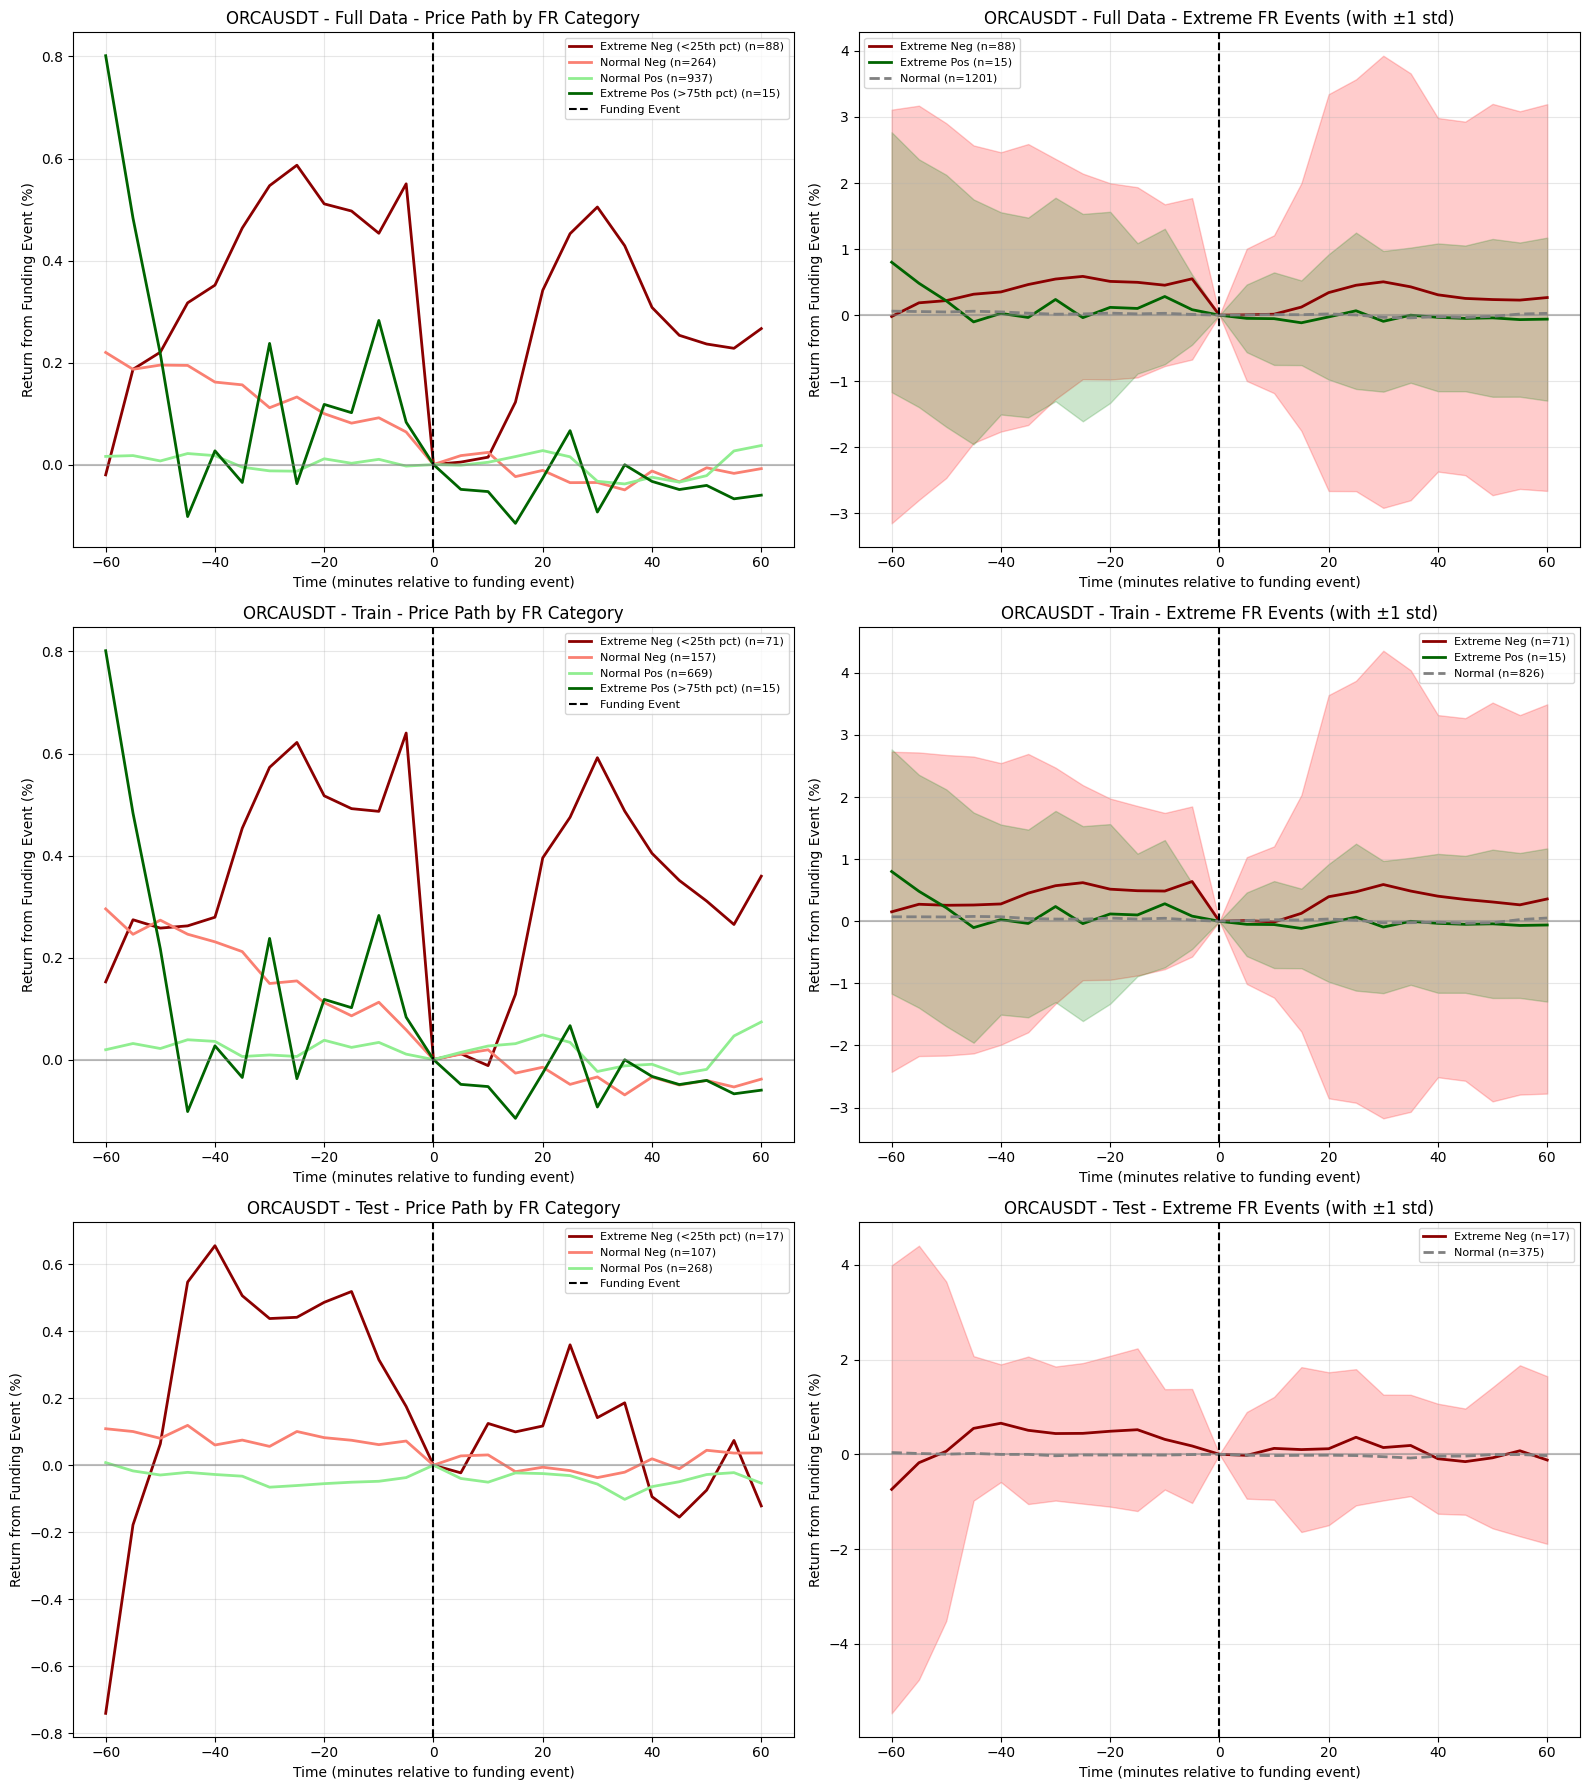

In [9]:
# PRICE PATH ANALYSIS (STANDALONE - SINGLE SYMBOL)
# ============================================================
# Run this cell to analyze average price path around funding events
# for a single ticker without running the full ML pipeline

required_analysis = True
SYMBOL_PATH = 'ORCAUSDT'

if required_analysis:
    TIMEFRAME_PATH = '5m'
    WINDOW_BARS = 12  # 12 bars = 60 minutes for 5m data
    FR_PERCENTILE_PATH = 0.25  # 0.25 = 25th/75th percentile, 0.10 = 10th/90th, etc.
    TEST_SIZE_PATH = 0.3  # 0.3 = 70% train / 30% test

    # Load and merge data
    df_futures = load_futures_data(SYMBOL_PATH, TIMEFRAME_PATH)
    df_spot = load_spot_data(SYMBOL_PATH, TIMEFRAME_PATH)
    df_funding = load_funding_rate(SYMBOL_PATH)
    df_merged = merge_all_data(df_futures, df_spot, df_funding)

    # Run price path analysis
    result = analyze_price_path(df_merged, SYMBOL_PATH, window_bars=WINDOW_BARS, fr_percentile=FR_PERCENTILE_PATH, test_size=TEST_SIZE_PATH, show_plots=True)


RUNNING SVM PIPELINE FOR ORCAUSDT
FR Percentile Threshold: 25th percentile
LOADING FUTURES (PERPS) DATA
Loaded 103355 rows of ORCAUSDT FUTURES data
Date range: 2024-12-06 15:00:00 to 2025-11-30 11:50:00

LOADING SPOT DATA
Loaded 103453 rows of ORCAUSDT SPOT data
Date range: 2024-12-06 13:00:00 to 2025-11-30 18:00:00

LOADING FUNDING RATE DATA
Loaded 2251 rows of ORCAUSDT FUNDING RATE data
Date range: 2024-12-06 16:00:00 to 2025-11-30 09:00:00

MERGING ALL DATA
After Futures + Spot merge: 103355 rows
After adding Funding Rate: 103355 rows
Rows with funding rate: 1304

CALCULATING DERIVED FEATURES
ML Features calculated successfully!
Total columns: 67

FUNDING RATE INTERVAL ANALYSIS

Total funding events: 1304

Interval Statistics (hours):
  Mean:   6.61
  Median: 4.00
  Min:    1.00
  Max:    48.00


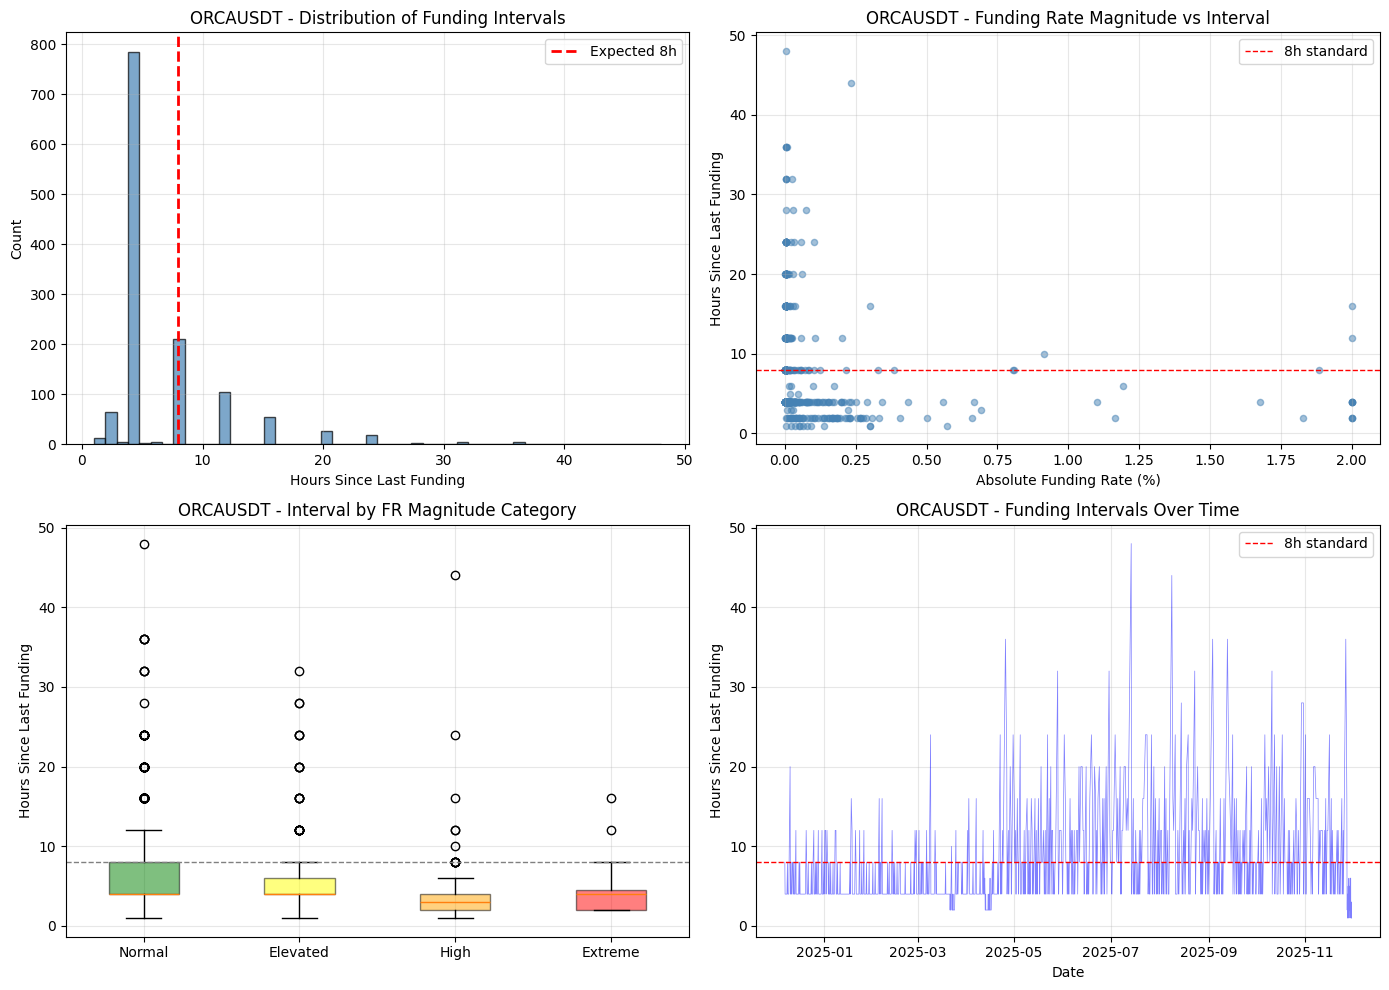


BASIS CORRELATION ANALYSIS
Total funding events: 1304
Extracted 16952 data points

Correlation between Basis and Funding Rate by Time Offset:
 offset  offset_minutes  correlation  n_samples
     -6             -30     0.697678       1304
     -5             -25     0.688042       1304
     -4             -20     0.686383       1304
     -3             -15     0.664855       1304
     -2             -10     0.639143       1304
     -1              -5     0.633790       1304
      0               0     0.736325       1304
      1               5     0.695640       1304
      2              10     0.696188       1304
      3              15     0.682746       1304
      4              20     0.689091       1304
      5              25     0.687848       1304
      6              30     0.684496       1304


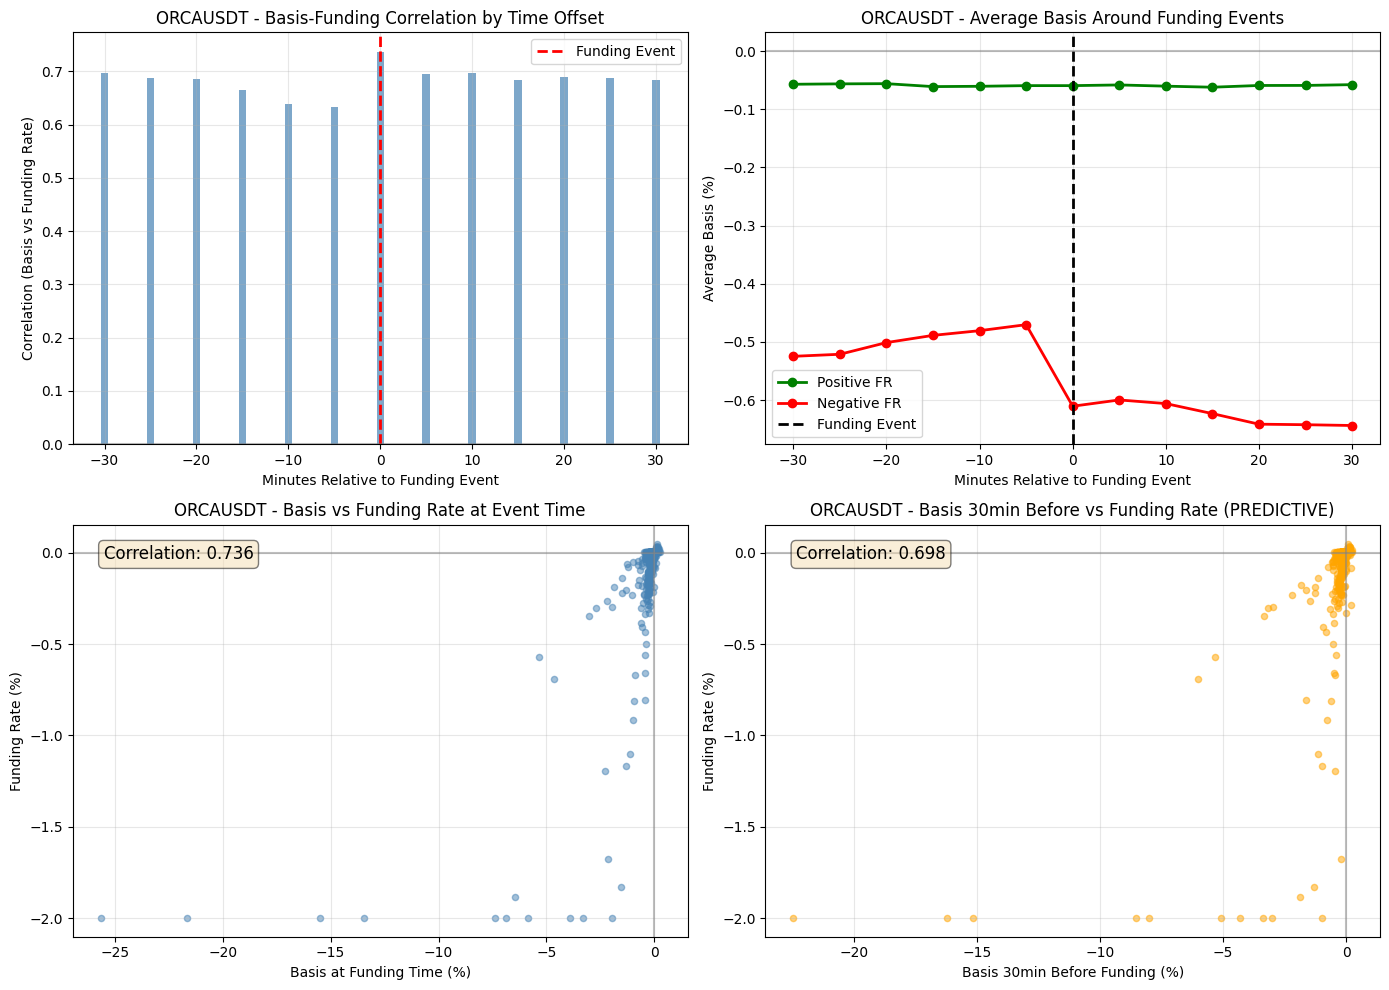


PREPARING ML DATA
Training candidates: 16939 rows

Funding Rate Distribution:
  25th percentile: -0.0022%  <-- THRESHOLD
After dropping NaN/inf: 16735 rows

TIME-BASED TRAIN/TEST SPLIT
Train set: 11714 samples
  Date range: 2024-12-07 15:00:00 to 2025-07-09 11:10:00
  Class 1: 2768 (23.6%)

Test set: 5021 samples
  Date range: 2025-07-09 11:15:00 to 2025-11-30 11:45:00
  Class 1: 1399 (27.9%)

BUILDING AND TRAINING SVM WITH HYPERPARAMETER TUNING
Input shape: 40 features
Training samples: 11714
Class 0: 8946, Class 1: 2768

Parameter grid: {'C': [0.1, 1, 10], 'gamma': ['scale', 0.01, 0.1], 'kernel': ['rbf']}
Running GridSearchCV (this may take a while)...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

----------------------------------------
GRID SEARCH RESULTS
----------------------------------------
Best parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV ROC-AUC: 0.9031
Number of support vectors: 5070

All parameter combinations:
                            

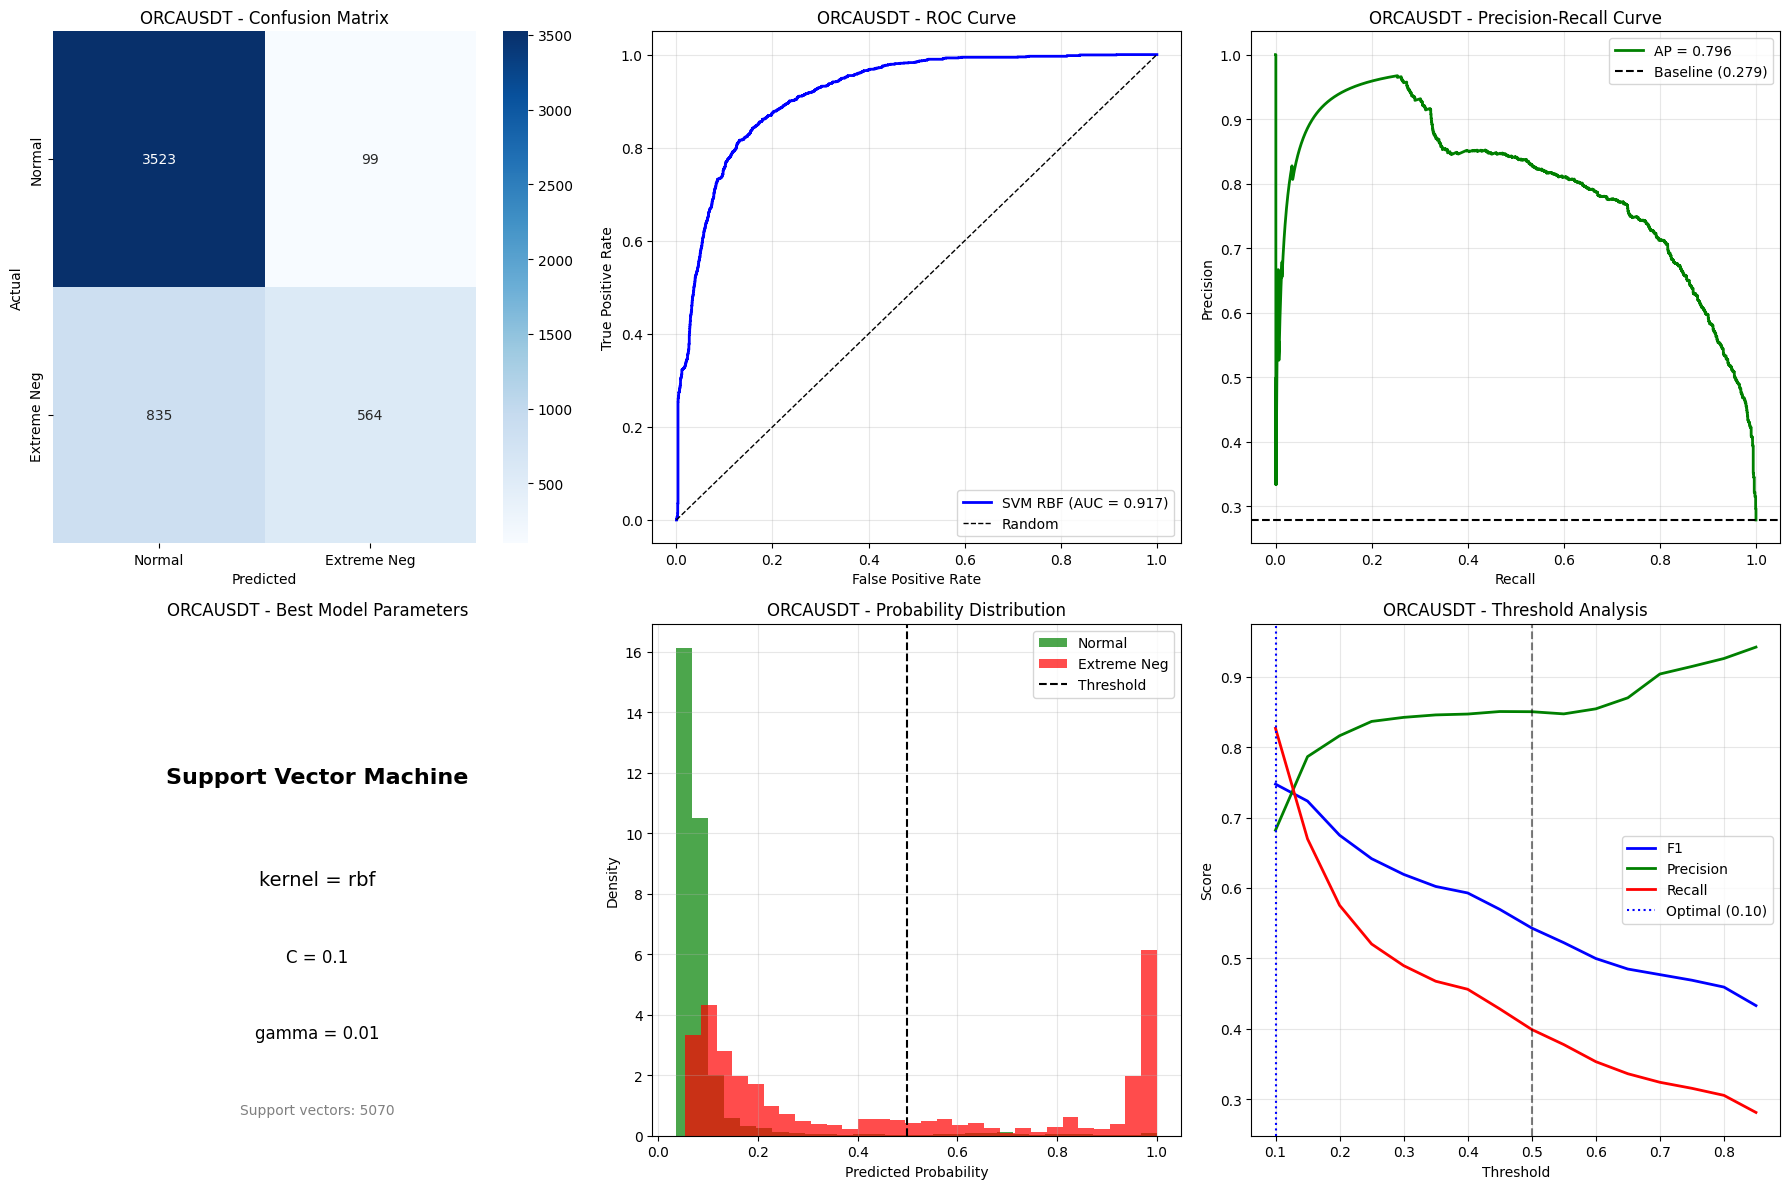


PER-FUNDING-EVENT ANALYSIS
Total funding events in test period: 397

Event-Level Metrics:
  Precision: 0.8065
  Recall:    0.4425
  F1 Score:  0.5714


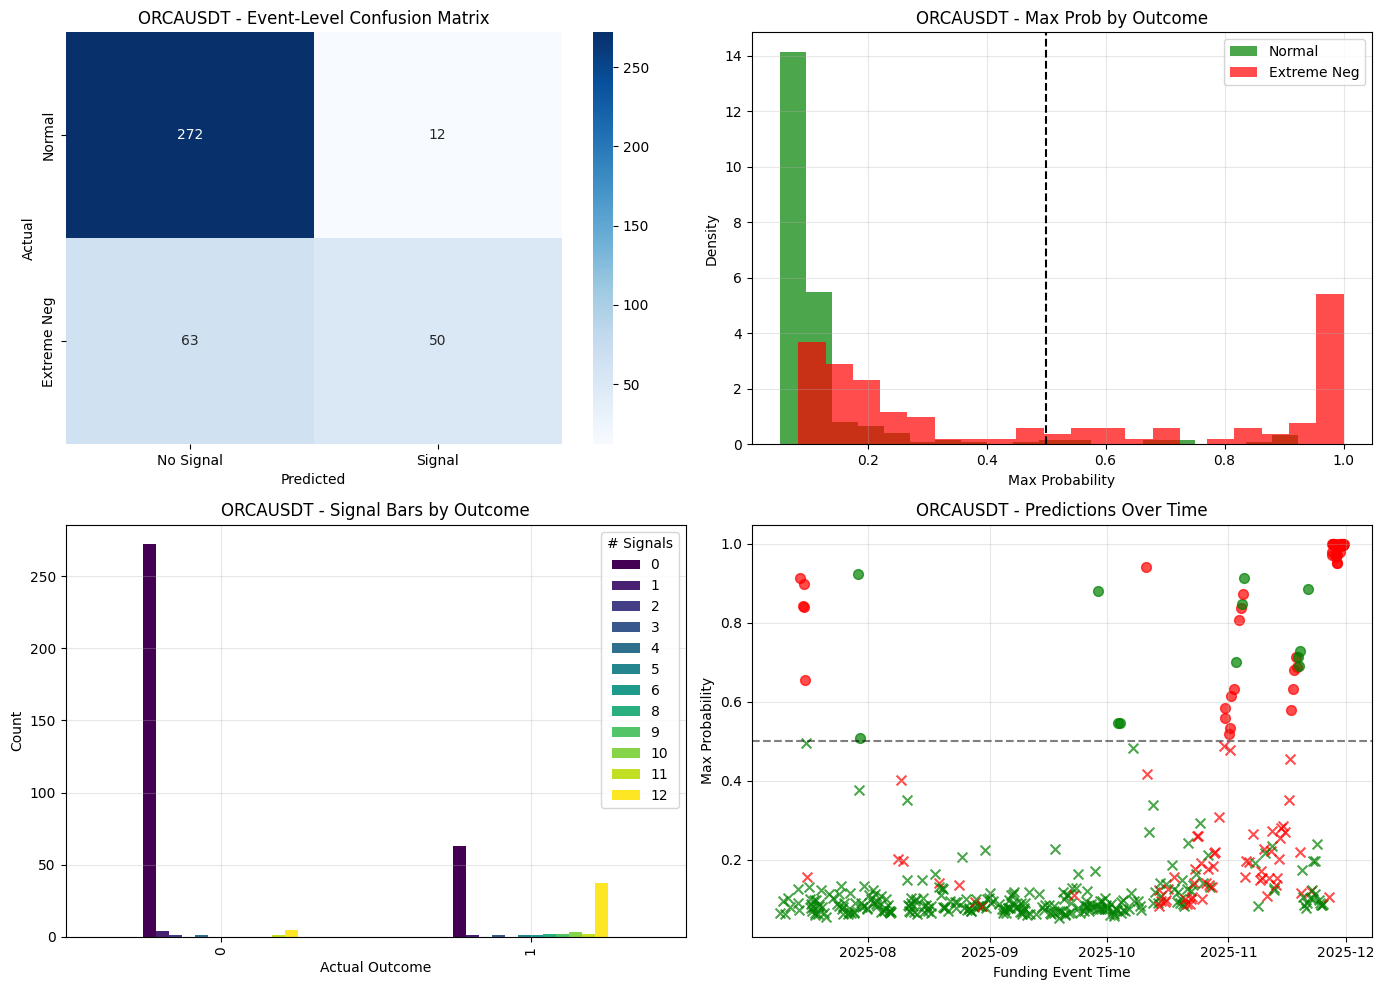


BACKTEST - SHORT ON EXTREME NEGATIVE PREDICTION
25th Percentile Threshold: -0.0022%
Signal Window: 6 bars (30 minutes)
Funding events in test period: 397

Total trades: 58
Total NET PnL: -2.2823%
Avg NET PnL: -0.0394%
Win rate (profitable trades): 50.0%
Prediction accuracy (correct extreme neg): 82.8%

--- SAMPLE TRADES (First 10) ---
       funding_time          entry_time  hold_time_min  entry_price  exit_price  actual_fr  price_pnl_pct  net_pnl_pct  correct_prediction
2025-07-14 16:00:00 2025-07-14 15:30:00           30.0        2.648       2.567  -0.003288       3.058912     2.938912                True
2025-07-15 08:00:00 2025-07-15 07:30:00           30.0        2.551       2.529  -0.003001       0.862407     0.742407                True
2025-07-15 12:00:00 2025-07-15 11:30:00           30.0        2.470       2.471  -0.002324      -0.040486    -0.160486                True
2025-07-15 16:00:00 2025-07-15 15:30:00           30.0        2.501       2.545  -0.000812      -1.759296 

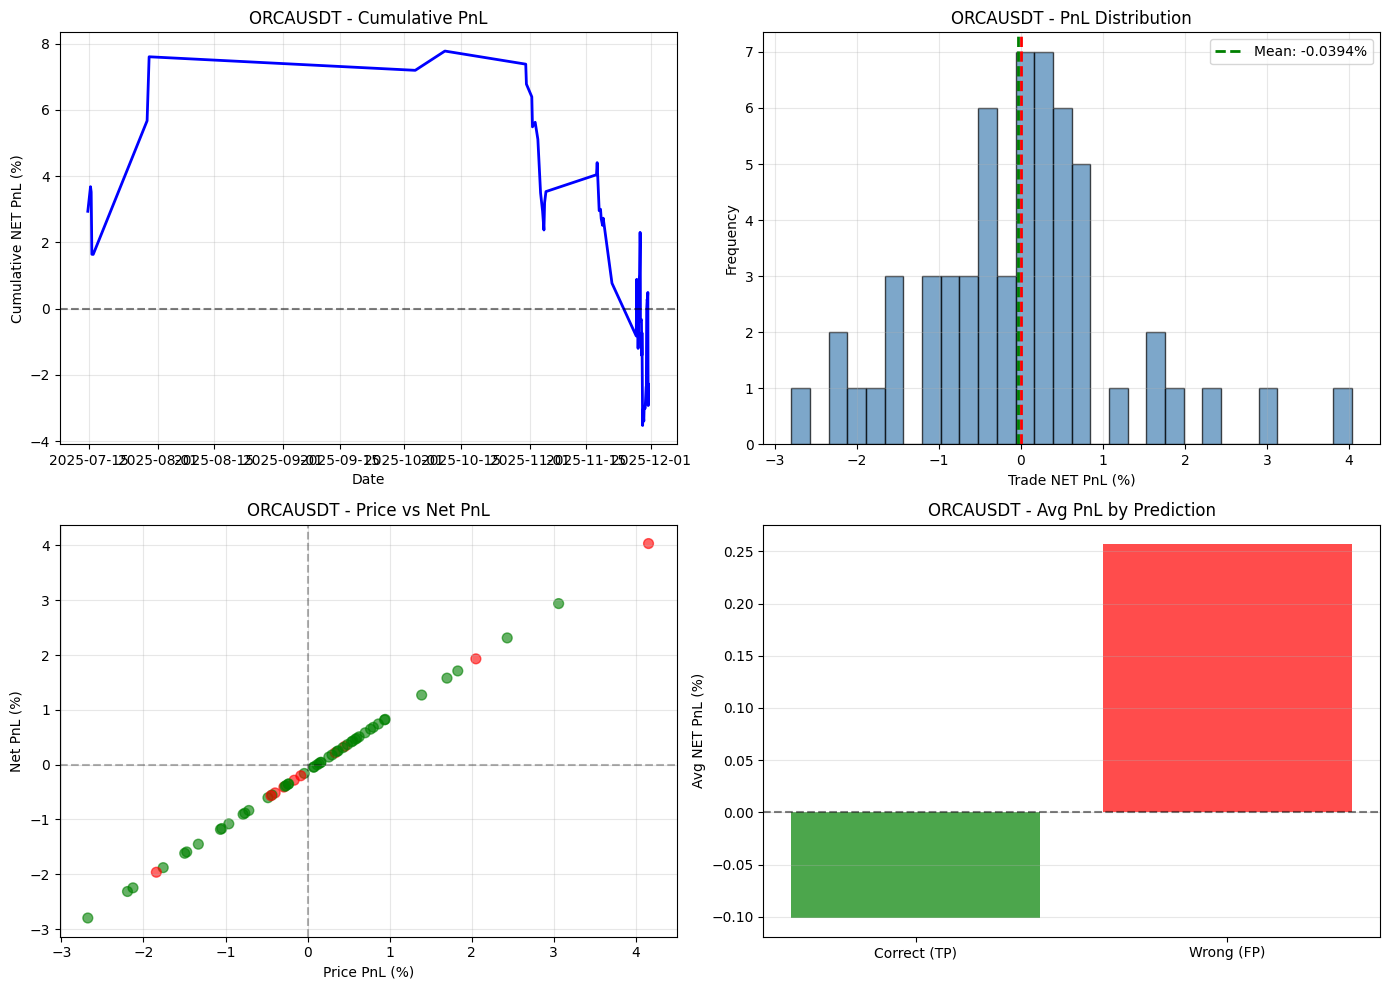


SAVING MODEL & RESULTS
Model saved to ORCAUSDT_svm_model.joblib
Scaler saved to ORCAUSDT_scaler.joblib
Features saved to ORCAUSDT_feature_cols.joblib
Trades saved to results/ORCAUSDT_SVM_trades.csv
Updated existing entry for ORCAUSDT (SVM) in backtest_comparison_summary.csv

SVM PIPELINE COMPLETE FOR ORCAUSDT


In [10]:
# RUN SINGLE SYMBOL
# ============================================================
SYMBOLS_PATH = [
    'LSKUSDT', 'RESOLVUSDT', 'ORCAUSDT',
     'SKLUSDT', 'AWEUSDT',
      'TNSRUSDT'
]

TIMEFRAME = '5m'
RANDOM_STATE = 42
FR_PERCENTILE = 0.25  # 0.25 = 25th percentile, 0.10 = 10th percentile, etc.
SIGNAL_WINDOW = 6

results = run_full_pipeline(
    symbol=SYMBOL_PATH,
    timeframe=TIMEFRAME,
    random_state=RANDOM_STATE,
    fr_percentile=FR_PERCENTILE,
    signal_window=SIGNAL_WINDOW,
    run_analysis=True,
    show_plots=True
)

In [11]:
# RUN MULTIPLE SYMBOLS
# ============================================================
# Per-symbol configuration: {symbol: (fr_percentile, signal_window)}
multiple_symbol_required = False
if multiple_symbol_required:
    SYMBOL_CONFIG = {
        'ORCAUSDT':    (0.25, 6),
        'AWEUSDT':     (0.25, 6),
        'LSKUSDT':     (0.10, 6),
        'MLNUSDT':     (0.25, 6),
        'RESOLVUSDT':  (0.25, 8),
    }

    TIMEFRAME = '5m'
    RANDOM_STATE = 42

    all_results = {}
    for symbol, (fr_pct, sig_win) in SYMBOL_CONFIG.items():
        print(f"\n{'='*80}")
        print(f"PROCESSING {symbol} (fr_percentile={fr_pct}, signal_window={sig_win})")
        print(f"{'='*80}")

        try:
            results = run_full_pipeline(
                symbol=symbol,
                timeframe=TIMEFRAME,
                random_state=RANDOM_STATE,
                fr_percentile=fr_pct,
                signal_window=sig_win,
                run_analysis=False,
                show_plots=False
            )
            all_results[symbol] = results
        except Exception as e:
            print(f"ERROR processing {symbol}: {e}")
            all_results[symbol] = {'error': str(e)}

In [12]:
# COMPARE RESULTS ACROSS SYMBOLS
# ============================================================

# df_summary = print_summary_comparison(all_results)